# Dictionary Initialization

In [5]:
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the hybrid predictor
betaValues = []
hybridMeanRegretValues = []
hybridMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

rwValues = []

# Import Data

In [6]:
from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)
from performanceMeasurement import * # this file contains the implementation of the performance measurement functions(like rmse, loglikelihood, regret, etc)

increment_type = "linear"
k = 10 # this parameter adjust the stepness of the curve "lamda increment" in the hybrid predictor

# Covariance Predictors

HYBRID MODEL PREDICTOR IMPLEMENTATION -> covMatrix = (1-x) * K + x * H

Where:
1. K is the covariance matrix calculated using a predictor like RW, EWMA, MGARCH 
2. H is the covariance matrix of the ExpandingWindow model
3. x is a weight between 0 and 1; 0 at the beginning of the quarter and 1 at the end of the quarter

# Validation Phase for Hybrid Model predictor (EW + RW)

In [7]:
# Loop through rw_memory values

def hybridPredictorValidationPhaseWithRw(rw_memory, startingDate, endingDate, rw_size_increment, prescientAlreadyPrinted, expandingWindowDict):
    '''
    this function is used to perform the validation phase of the RW predictor; it's used to find the best memory size of the window for the rw predictor.
    Grid search is used and the performance of the M hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while rw_memory < 1000:

        rwDict = rolling_window(validationDataWithPercentageChange, rw_memory) 

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
            
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        # filter the rwDict dictionary to have only the timestamps between the start and end date
        rwDict = {t: rwDict[t] for t in rwDict.keys() if t >= start_date and t <= end_date}

        # filter the expandingWindowDict dictionary to have only the timestamps between the start and end date
        expandingWindowDict = {t: expandingWindowDict[t] for t in expandingWindowDict.keys() if t >= start_date and t <= end_date}

        # filter the dataset to have only the timestamps between the start and end date
        filteredDataset = stocksPercentageChangeReturn.loc[start_date:end_date]

        # now i can get the hybrid predictor covariance matrixes, this because i have the ewma and prescient covariance matrixes filtered by the start and end date(validation period)
        hybridModelDict = hybridPredictor(stocksPercentageChangeReturn, filteredDataset, expandingWindowDict, rwDict, start_date, increment_type)

        names = ["HYBRID", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [hybridModelDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            if names[i] == "PRESCIENT":
                returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]
            
            else:
                returns_temp = validationDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]

            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

        #
        # REGRETS
        #

        for name in daily_log_likelihoods:
            daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]
            
        for name in daily_regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                hybridMeanRegretValues.append(regretMetrics[0])

        # copy the log-likelihoods dictionary
        daily_log_likelihoods_copy = daily_log_likelihoods.copy()
        prescientMeanlogLikelihoodValues = []

        # do the same thing for log-likelihoods dictionary
        for name in daily_log_likelihoods_copy:
            quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

            if name != "PRESCIENT":
                # save the log-likelihood mean values to plot a chart
                hybridMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
            
            if name == "PRESCIENT":
            # i'm writing the prescient predictor only once, because it's the same for every rw_memory value

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
        
        # save the rw value to plot a chart
        rwValues.append(rw_memory)

        # Increment beta
        rw_memory += rw_size_increment

    print("dimension of hybridDict: " + str(len(hybridModelDict)))
    print("first timestamp of hybridDict: " + str(list(hybridModelDict.keys())[0]))
    print("last timestamp of hybridDict: " + str(list(hybridModelDict.keys())[-1]))
    
    # return the fundamental values to plot the charts
    return rwValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues

dimension of hybridDict: 635
first timestamp of hybridDict: 2019-03-11 00:00:00
last timestamp of hybridDict: 2021-09-14 00:00:00
max_pointsX: [80, 160]
max_pointsY: [8.4, 8.4]
min_pointsX: [40, 990]
min_pointsY: [0.3, 0.3]


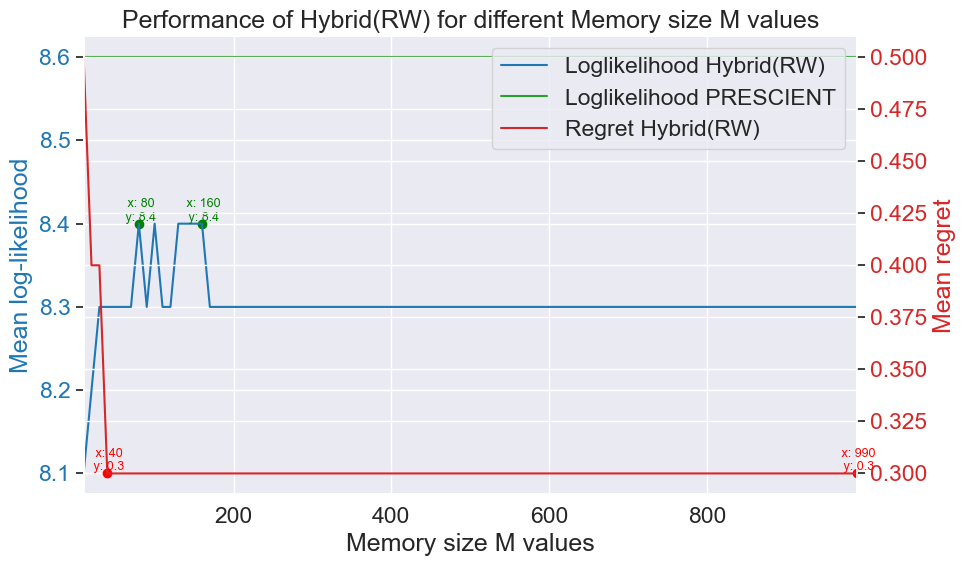

In [8]:
# grid search run for the RW predictor
rwValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues = hybridPredictorValidationPhaseWithRw(10, startingValidationDate, endingValidationDate, 10, prescientAlreadyPrinted, expandingWindowDict)

# plot the performance of the RW predictor in terms of log-likelihood and regret
plotPerformancePredictor(rwValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValues, hybridMeanRegretValues, "Hybrid(RW)", "Memory size M")

In [9]:
# write the value of regret and loglikelihood for the rw memory value = 130
# take the index for which the rw memory is 130
index = rwValues.index(180)
print("index value: ", index)
print("hybridMeanRegretValues: " + str(hybridMeanRegretValues[index]))
print("hybridMeanlogLikelihoodValues: " + str(hybridMeanlogLikelihoodValues[index]))


index value:  17
hybridMeanRegretValues: 0.3
hybridMeanlogLikelihoodValues: 8.3


# Test Phase for Hybrid Model predictor (EW + RW)

In [10]:
# calculate the rolling window predictor inside the test phase
start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

# select the best memory size for the RW predictor
rw_memory = predictorsConfiguration["HYBRIDRW_memorySize"]

rwDict = rolling_window(testDataWithPercentageChange, rw_memory)

# filter the rwDict dictionary to have only the timestamps between the start and end date
rwDict = {t: rwDict[t] for t in rwDict.keys() if t >= start_date and t <= end_date}

print("len of the rwDict dictionary: " + str(len(rwDict)))

# print the first key of the dictionary
print("first timestamp of rwDict: " + str(list(rwDict.keys())[0]))
print(rwDict[list(rwDict.keys())[0]])


len of the rwDict dictionary: 308
first timestamp of rwDict: 2021-10-12 00:00:00
          7         20990     21177
7      0.000148  0.000045  0.000067
20990  0.000045  0.000119  0.000036
21177  0.000067  0.000036  0.000066


In [11]:
# filter the expandingWindowDict dictionary to have only the timestamps between the start and end date ( for the test phase)

expandingWindowDictForTest = {t: expandingWindowDict[t] for t in expandingWindowDict.keys() if t >= start_date and t <= end_date}

print("len of the expandingWindowDict dictionary: " + str(len(expandingWindowDictForTest)))
print("first timestamp of expandingWindowDict: " + str(list(expandingWindowDictForTest.keys())[0]))
print(expandingWindowDictForTest[list(expandingWindowDictForTest.keys())[0]])

len of the expandingWindowDict dictionary: 327
first timestamp of expandingWindowDict: 2021-09-15 00:00:00
          7         20990     21177
7      0.000165  0.000018  0.000046
20990  0.000018  0.000106  0.000027
21177  0.000046  0.000027  0.000075


In [12]:
# HYBRID MODEL IMPLEMENTATION
# i have defined inside the 2 box above the expanding window and the rw predictors; now i will use them to implement the hybrid model

# the hybrid model is a combination of the expanding window and the rw predictors; the lambda parameter is incremented linearly in each quarter. so it is like the inverse of the number of days in a quarter
hybridModelDict =  hybridPredictor(stocksPercentageChangeReturn, testDataWithPercentageChange, expandingWindowDictForTest, rwDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(rwDict)))

print("first 3 elements of the hybrid model dictionary: ")
for key in list(hybridModelDict.keys())[:3]:
    print(key, hybridModelDict[key])

dimension of the hybrid model dictionary: 308
first 3 elements of the hybrid model dictionary: 
2021-10-12 00:00:00           7         20990     21177
7      0.000148  0.000045  0.000067
20990  0.000045  0.000119  0.000036
21177  0.000067  0.000036  0.000066
2021-10-13 00:00:00           7         20990     21177
7      0.000142  0.000042  0.000065
20990  0.000042  0.000115  0.000034
21177  0.000065  0.000034  0.000065
2021-10-14 00:00:00           7         20990     21177
7      0.000153  0.000057  0.000069
20990  0.000057  0.000126  0.000039
21177  0.000069  0.000039  0.000064


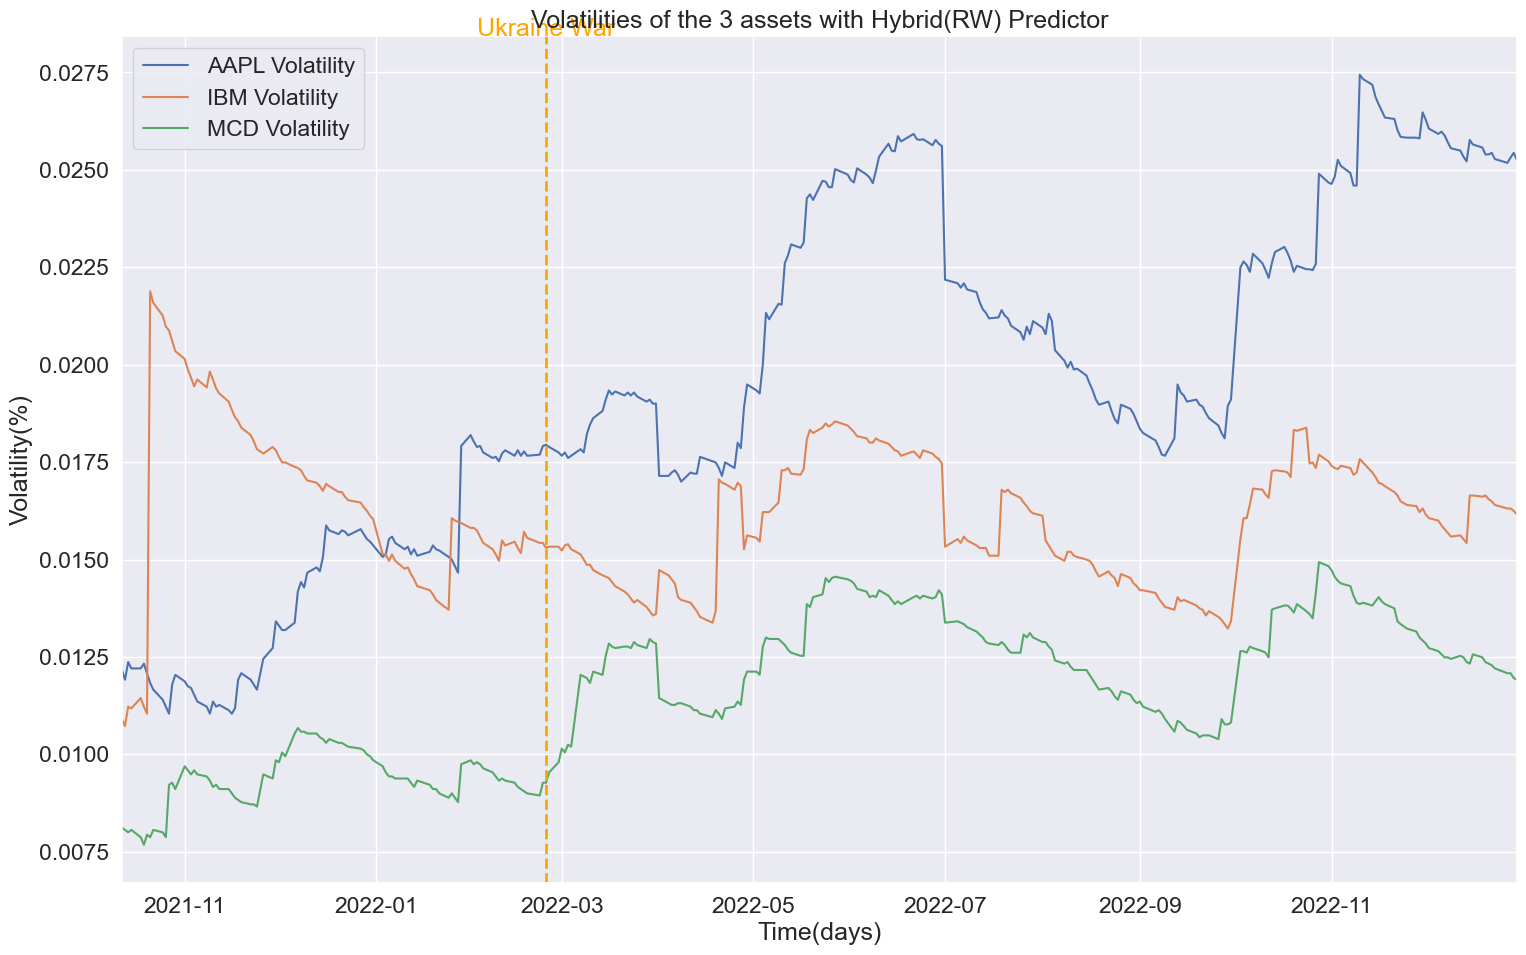

In [13]:
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(RW)')

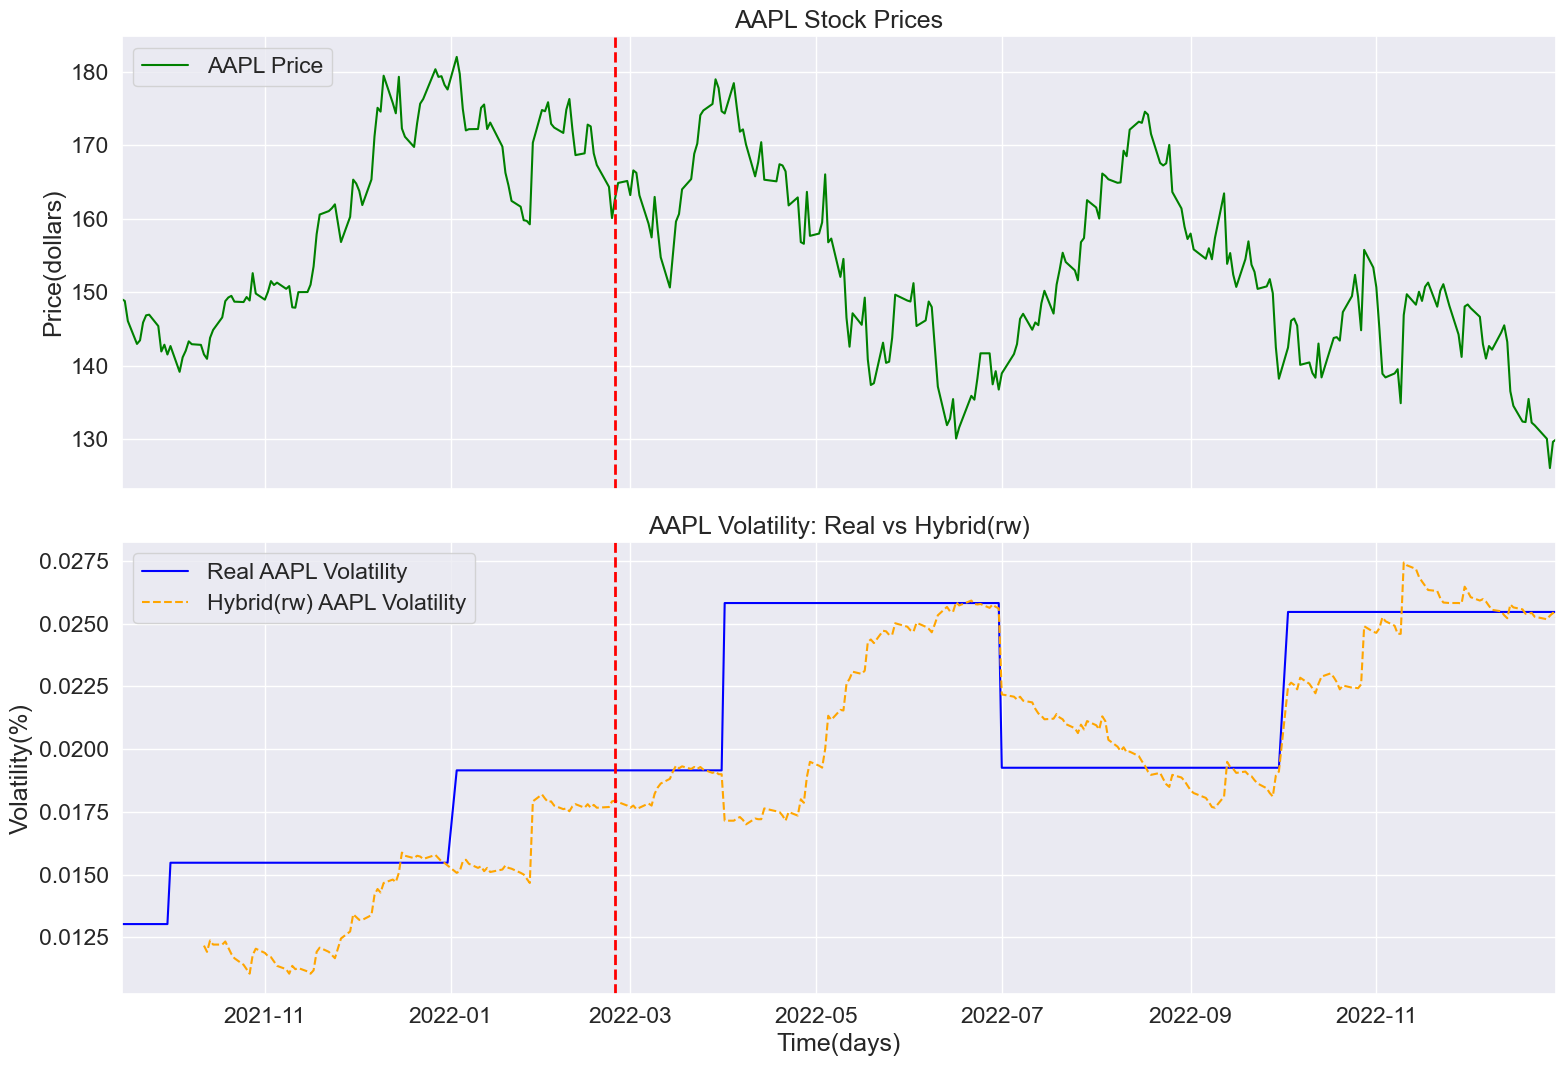

In [14]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL', "Hybrid(rw)")

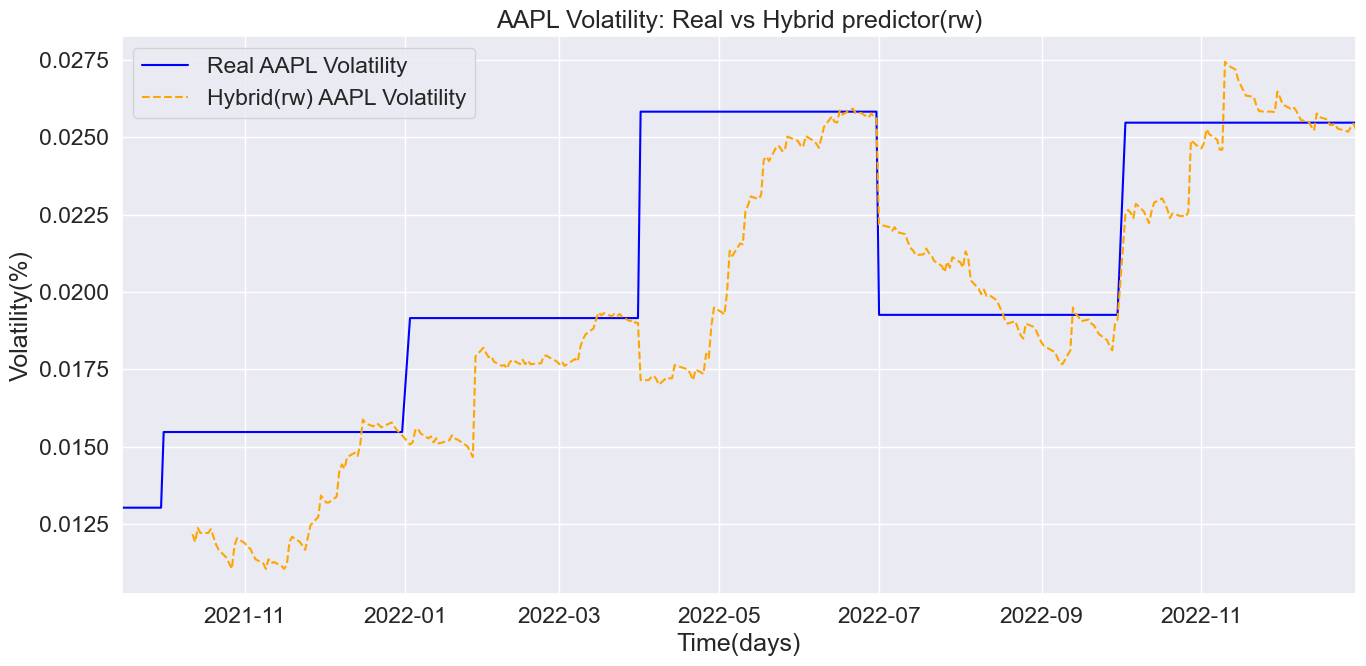

In [15]:
####################### code for test ####################################

def plot_prices_volatilities_for_ewAndRWTest(real_volatility, real_volatility_startDate, real_volatility_endDate, hybrid_volatility, asset_name):
    # filter the real volatility between the start and end date
    real_volatility_startDate = pd.to_datetime(real_volatility_startDate)
    real_volatility_endDate = pd.to_datetime(real_volatility_endDate)

    # Correct way to filter using & operator and parentheses
    real_volatility_filtered = real_volatility[(real_volatility.index >= real_volatility_startDate) & (real_volatility.index <= real_volatility_endDate)]

    plt.figure(figsize=(14, 7))

    # Plot real and rolling window volatilities
    plt.plot(real_volatility_filtered, label='Real AAPL Volatility', color='blue')
    plt.plot(hybrid_volatility, label='Hybrid(rw) AAPL Volatility', color='orange', linestyle='--')
    plt.title('AAPL Volatility: Real vs Hybrid predictor(rw)')
    plt.xlabel('Time(days)')
    plt.ylabel('Volatility(%)')
    plt.legend(loc='upper left')

    # Set x-axis limits to match the start and end dates
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Set x-axis limits to match the start and end dates
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)
    plt.xlim(left=real_volatility_startDate, right=real_volatility_endDate)

    # Show the plot
    plt.tight_layout()
    plt.show()


# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_ewAndRWTest(df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL')
##########################################################################

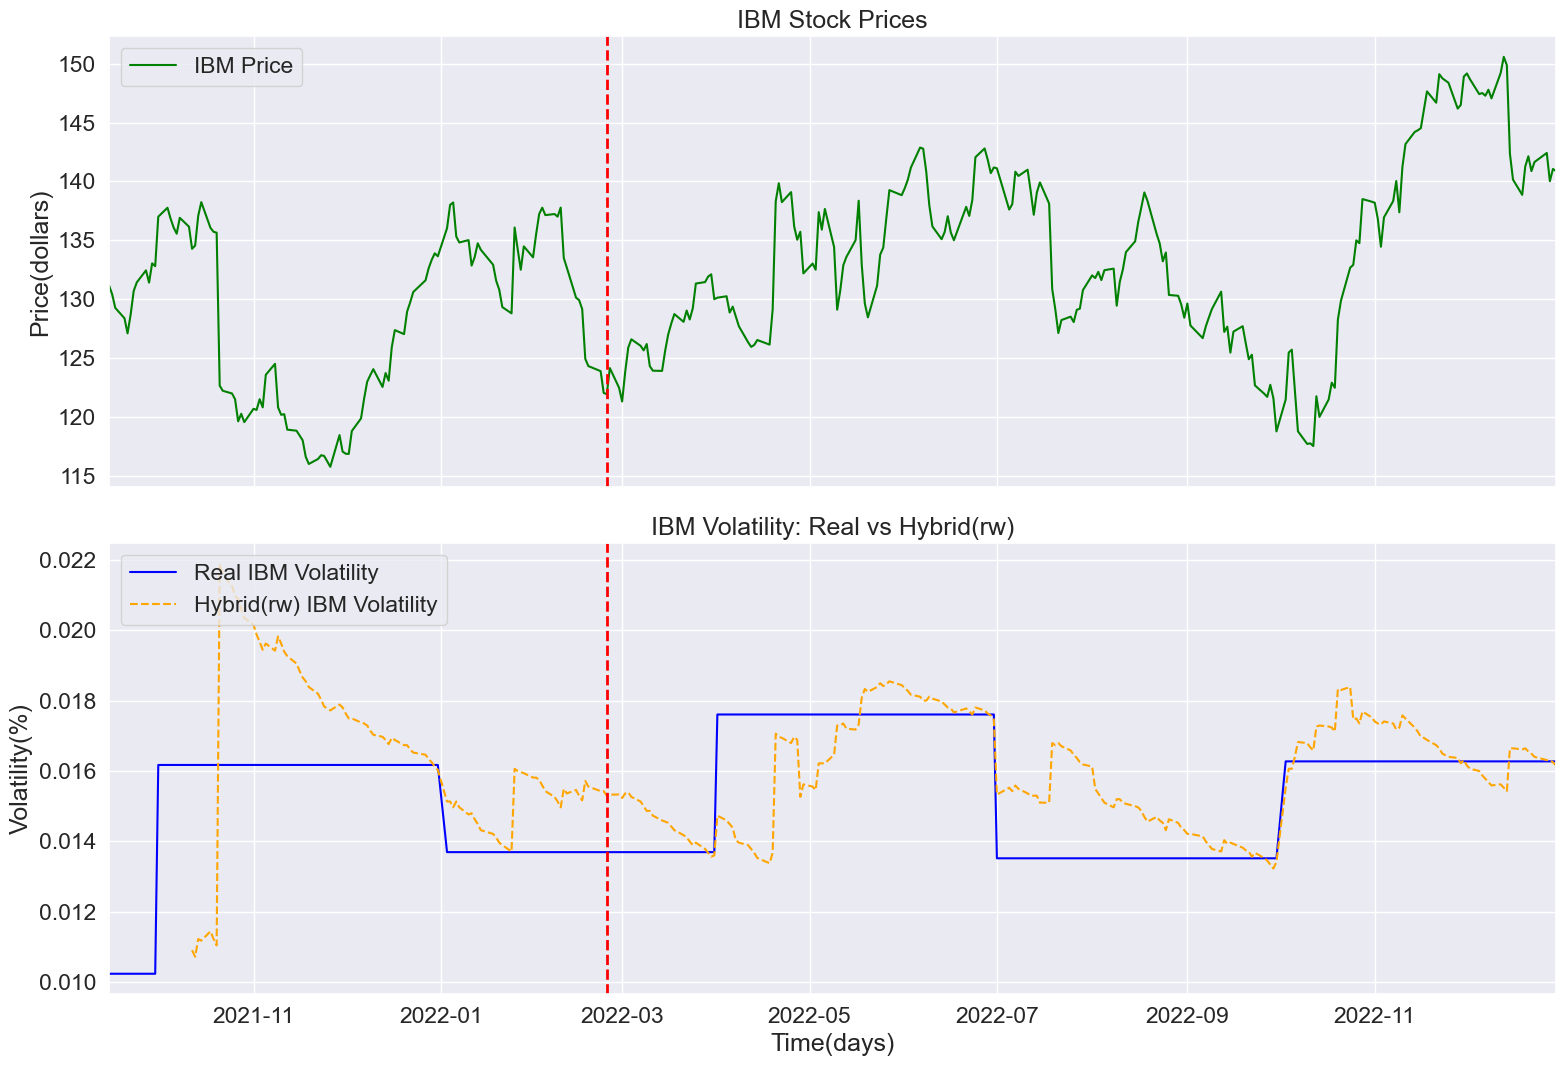

In [16]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_ibm['IBM Volatility'], 'IBM', "Hybrid(rw)")

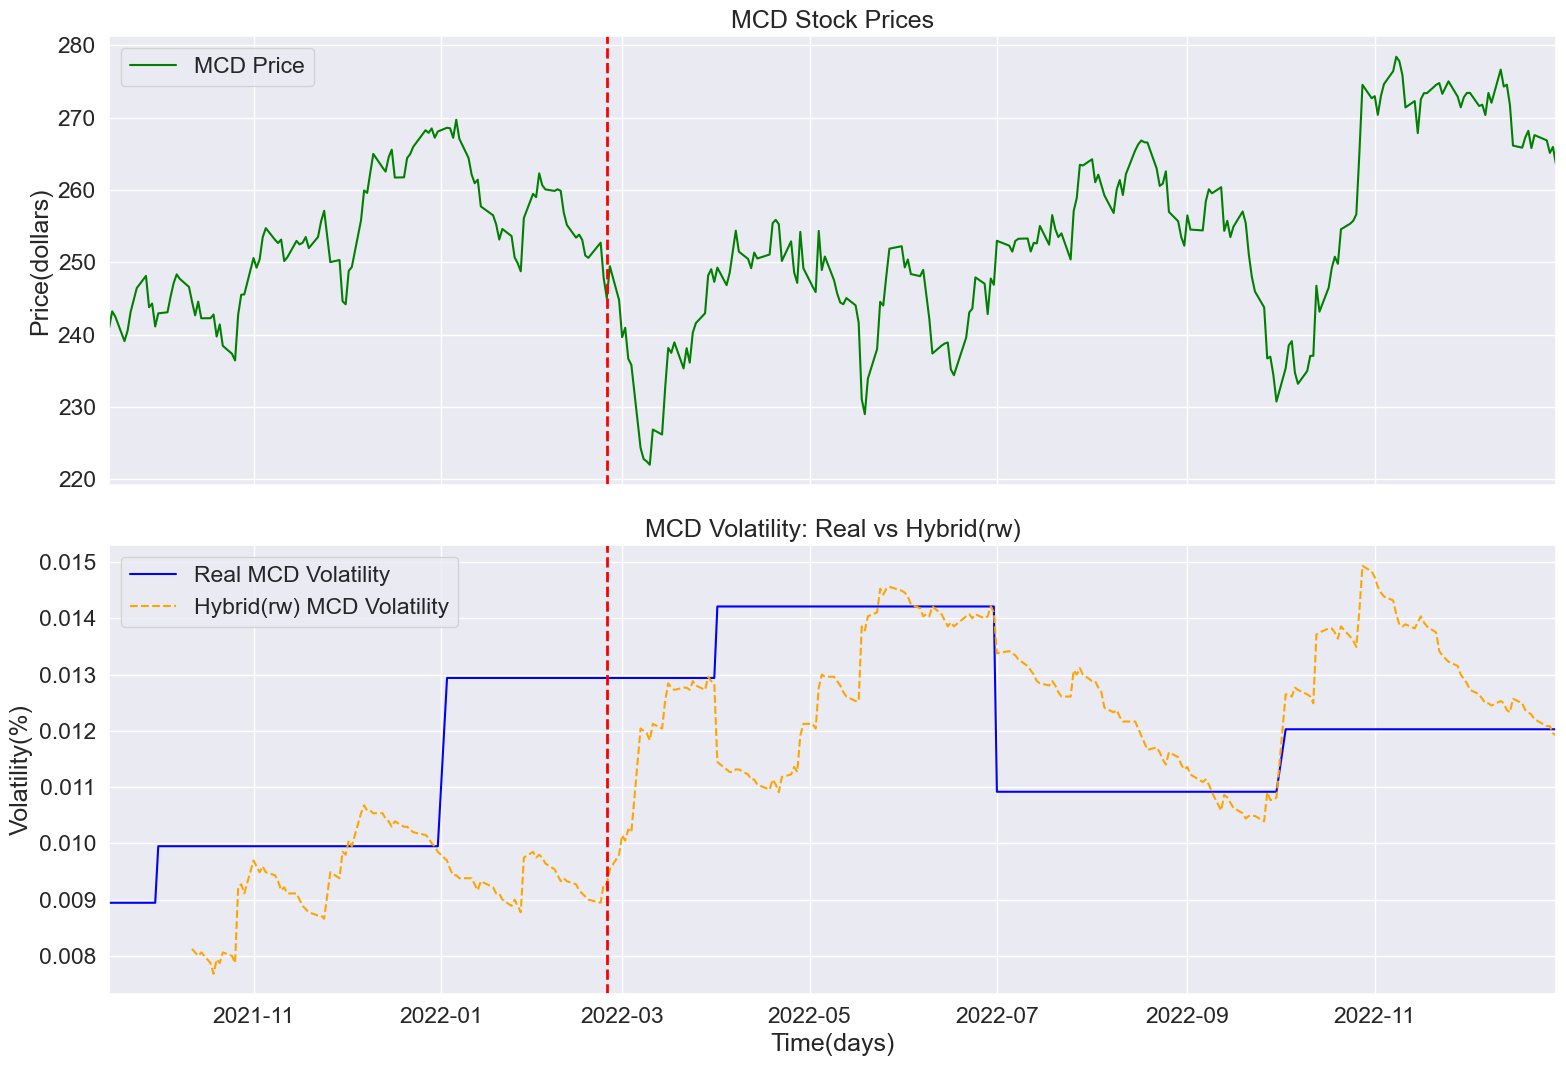

In [17]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_mcd['MCD Volatility'], 'MCD', "Hybrid(rw)")

lenght of the hybrid model dictionary: 308
lenght of the prescient dictionary: 3272
size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


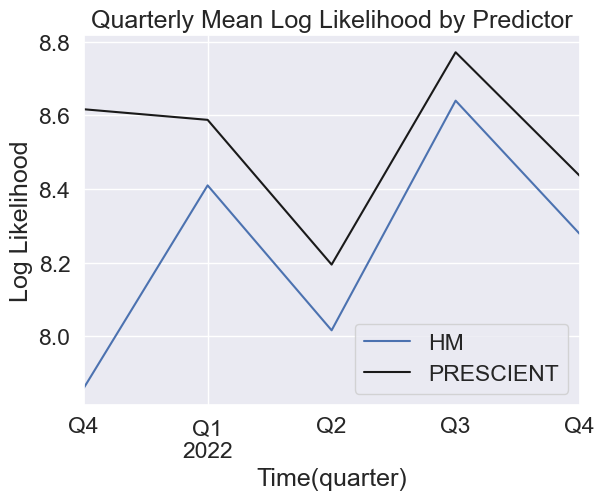



meanRegret: 0.300
stdRegret: 0.200
maxRegret: 0.800


meanLoglikelihoodHM: 8.200
stdLoglikelihoodHM: 0.300
maxLoglikelihoodHM: 8.600


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800
lenght of prescientDict:  3272
lenght of hybridDict:  308
lenght of predictorDict:  308

HM RMSE
mean: 0.0128988004
std: 0.0026786316
max: 0.0179494284
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.011397133891636378, Timestamp('2022-03-31 00:00:00'): 0.01265183238844042, Timestamp('2022-06-30 00:00:00'): 0.01794942843355824, Timestamp('2022-10-02 00:00:00'): 0.01010786582008001, Timestamp('2022-12-29 00:00:00'): 0.012387741276594722}


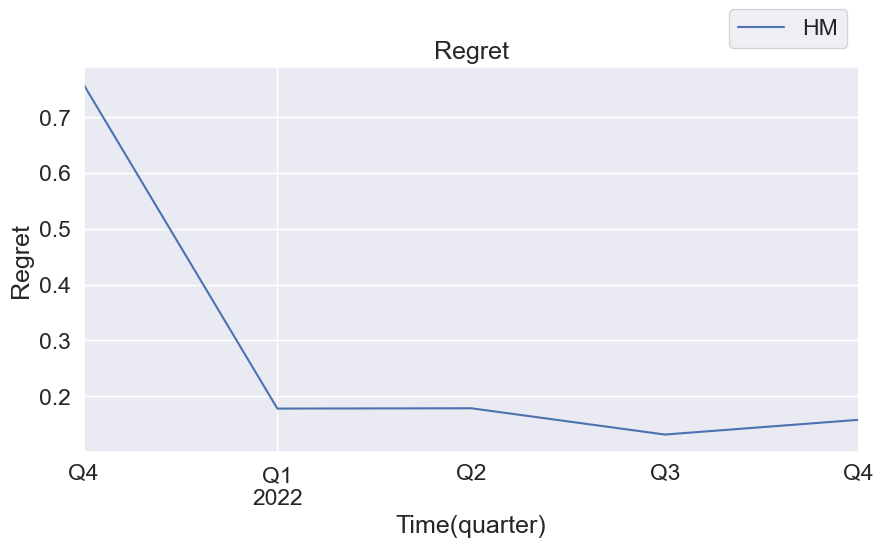

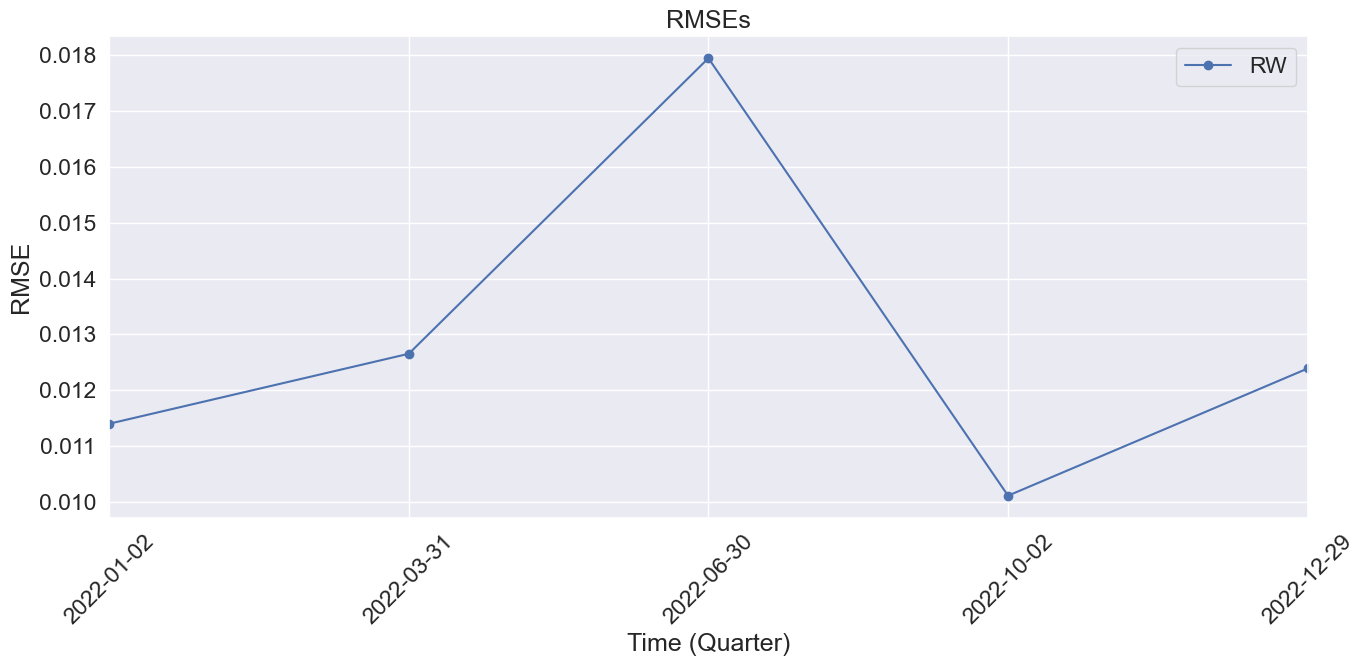

lenght of volatility_dict_aapl:  308
lenght of volatility_dict_aaapl_hybrid:  308
lenght of RMSEs_aapl:  5
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.05325897111656908, Timestamp('2022-03-31 00:00:00'): 0.04828055851034416, Timestamp('2022-06-30 00:00:00'): 0.07172646353849244, Timestamp('2022-10-02 00:00:00'): 0.03786098564057365, Timestamp('2022-12-29 00:00:00'): 0.041303881362962966}


RMSEs for AAPL
mean: 0.0504861720
std: 0.0118946452
max: 0.0717264635


RMSEs for IBM
mean: 0.0404968352
std: 0.0080269639
max: 0.0537913149


RMSEs for MCD
mean: 0.0407815042
std: 0.0077220996
max: 0.0545065546


In [18]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "PRESCIENT"]

print("lenght of the hybrid model dictionary: " + str(len(hybridModelDict)))
print("lenght of the prescient dictionary: " + str(len(prescientDict)))

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        hybrid: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        hybrid: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Regret')  # Set the y-axis label
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        hybridMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of hybridDict: ", len(hybridModelDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}

volatility_dict_aapl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_mcd.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_hybrid: ", len(volatility_dict_aapl_hybrid_filtered))
# get the rmse of single assets. i take just aapl, ibm and mcd
        
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_hybrid_filtered, volatility_dict_ibm_hybrid_filtered, volatility_dict_mcd_hybrid_filtered, start_date)

Now here i store all the variables that i need to pass to other notebooks.

In [19]:
#volatility_dict_aapl_hybrid_filtered
hybrid_rw_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
hybrid_rw_volatilities["AAPL"] = volatility_dict_aapl_hybrid_filtered
hybrid_rw_volatilities["IBM"] = volatility_dict_ibm_hybrid_filtered
hybrid_rw_volatilities["MCD"] = volatility_dict_mcd_hybrid_filtered

# store the dictionary
%store hybrid_rw_volatilities

Stored 'hybrid_rw_volatilities' (dict)


# HYBRID PREDICTOR VS NORMAL PREDICTOR PERFOMANCE COMPARISON(RW)

size of the first predictor: 308
size of the second predictor: 308
size of the third predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00
first timestamp of the third predictor: 2021-10-12 00:00:00


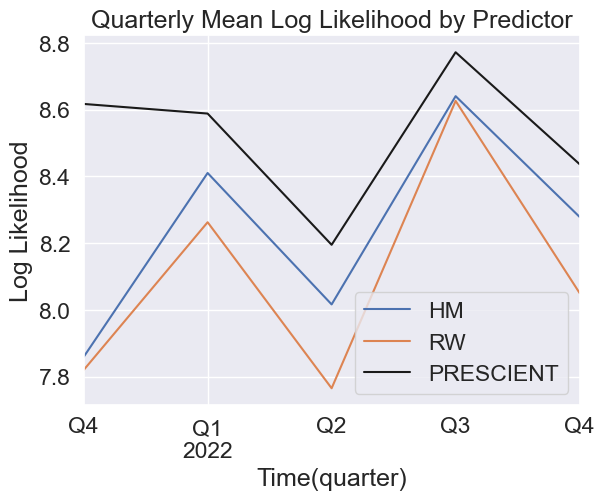



meanRegret: 0.400
stdRegret: 0.200
maxRegret: 0.800


meanLoglikelihoodHM: 8.200
stdLoglikelihoodHM: 0.300
maxLoglikelihoodHM: 8.600


meanLoglikelihoodRW: 8.100
stdLoglikelihoodRW: 0.300
maxLoglikelihoodRW: 8.600


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800


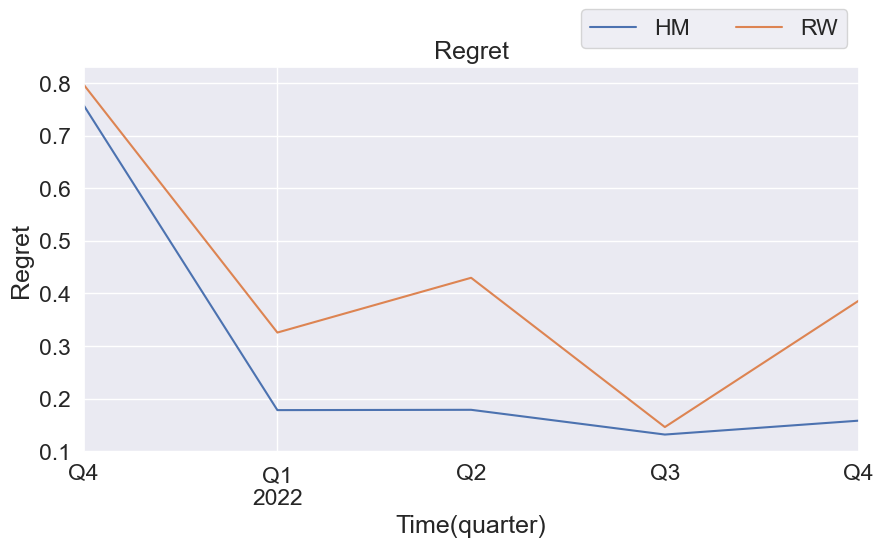

In [20]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "RW", "PRESCIENT"]

rw_memory = 50
rwDict = rolling_window(testDataWithPercentageChange, rw_memory)

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, rwDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 0(hybrid dict)
prescientDictionary = predictors[2]
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[2] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))
print("size of the third predictor: " + str(len(predictors[2])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])
assert len(predictors[0]) == len(predictors[2])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()
assert predictors[0].keys() == predictors[2].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))
print("first timestamp of the third predictor: " + str(list(predictors[2].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Regret')  # Set the y-axis label
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        hybridMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")

# Validation Phase for Hybrid Model predictor (EW + EWMA)

In [21]:
# Loop through beta values
# ewma_halflife = 100
# beta = 2 ** (-1 / ewma_halflife)
# beta = 0.1

def hybridPredictorValidationPhaseWithEwma(betaValue, startingDate, endingDate, betaIncrement, prescientAlreadyPrinted, expandingWindowDict):
    '''
    this function is used to perform the validation phase of the hybrid predictor; it's used to find the best beta value for the EWMA predictor part of this hybrid model.
    Grid search is used and the performance of the beta hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while betaValue < 1:

        ewma_halflife = -np.log(2) / np.log(betaValue)
        
        # obtain the ewma covariance matrixes
        ewmaDict = dict(_ewma_cov(validationDataWithPercentageChange, halflife=ewma_halflife))

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
        
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        # filter the ewmaDict dictionary by the start and end date
        ewmaDict = {t: ewmaDict[t] for t in ewmaDict.keys() if t >= start_date and t <= end_date}

        # filter the expandingWindowDict dictionary by the start and end date
        expandingWindowDict = {t: expandingWindowDict[t] for t in expandingWindowDict.keys() if t >= start_date and t <= end_date}

        # filter the stocksPercentageChangeReturn dataset by the start and end date
        filteredDataset = stocksPercentageChangeReturn.loc[start_date:end_date]
        
        # now i can get the hybrid predictor covariance matrixes, this because i have the ewma and prescient covariance matrixes filtered by the start and end date(validation period)
        hybridModelDict =  hybridPredictor(stocksPercentageChangeReturn, filteredDataset, expandingWindowDict, ewmaDict, start_date, increment_type, k)

        names = ["HYBRID", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [hybridModelDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
            returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]
            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


        #
        # REGRETS
        #

        for name in daily_log_likelihoods:
            daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]
            
        for name in daily_regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                hybridMeanRegretValues.append(regretMetrics[0])


        # copy the log-likelihoods dictionary
        daily_log_likelihoods_copy = daily_log_likelihoods.copy()

        # do the same thing for log-likelihoods dictionary
        for name in daily_log_likelihoods_copy:
            quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

            if name != "PRESCIENT":

                # save the loglikelihood mean values to plot a chart
                hybridMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
                
            if name == "PRESCIENT" and prescientAlreadyPrinted == False:
                prescientAlreadyPrinted = True

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValue = logLikelihoodMetrics[0]

        # save every fundamental value to plot a chart 
        betaValues.append(betaValue)

        # Increment beta
        betaValue += betaIncrement

    print("dimension of hybridDict: " + str(len(hybridModelDict)))
    print("first timestamp of hybridDict: " + str(list(hybridModelDict.keys())[0]))
    print("last timestamp of hybridDict: " + str(list(hybridModelDict.keys())[-1]))

    # return the fundamental values to plot a chart
    return betaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue

c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tes

dimension of hybridDict: 654
first timestamp of hybridDict: 2019-02-11 00:00:00
last timestamp of hybridDict: 2021-09-14 00:00:00
max_pointsX: [0.9200000000000007, 0.9900000000000008]
max_pointsY: [8.3, 8.3]
min_pointsX: [0.9300000000000007, 0.9900000000000008]
min_pointsY: [0.3, 0.3]


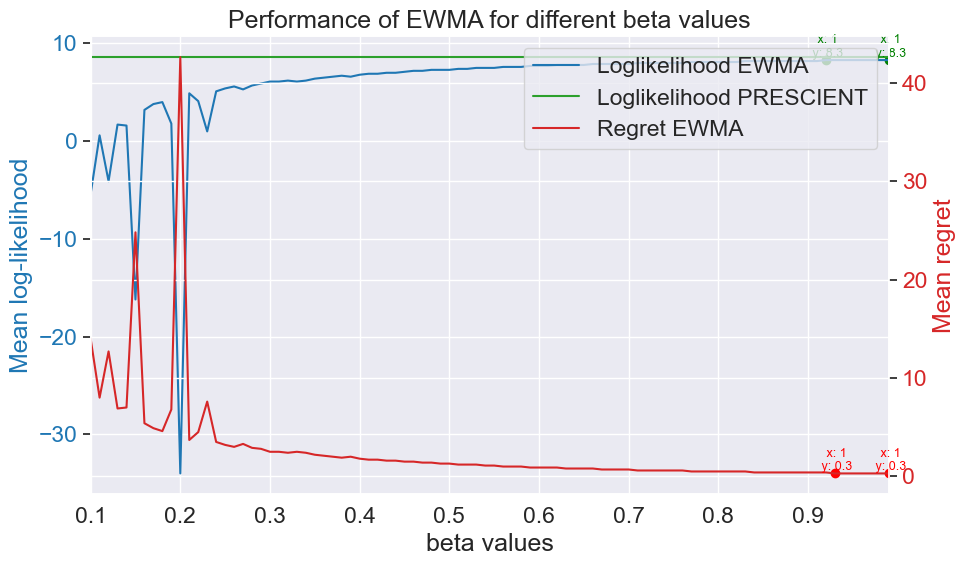

In [22]:
# first run for grid search -> this is a general run to cover the entire range of beta values

# clear the lists to make another run of the grid search
betaValues.clear()
hybridMeanRegretValues.clear()
hybridMeanlogLikelihoodValues.clear()
prescientMeanlogLikelihoodValue = 0

betaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = hybridPredictorValidationPhaseWithEwma(0.1, startingValidationDate, endingValidationDate, 0.01, prescientAlreadyPrinted, expandingWindowDict)

plotPerformancePredictor(betaValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, hybridMeanRegretValues, "EWMA", "beta")

c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2
c:\Users\chiod\Desktop\MyData\universita\tes

dimension of hybridDict: 654
first timestamp of hybridDict: 2019-02-11 00:00:00
last timestamp of hybridDict: 2021-09-14 00:00:00
max_pointsX: [0.92, 0.9990000000000001]
max_pointsY: [8.3, 8.3]
min_pointsX: [0.925, 0.9990000000000001]
min_pointsY: [0.3, 0.3]


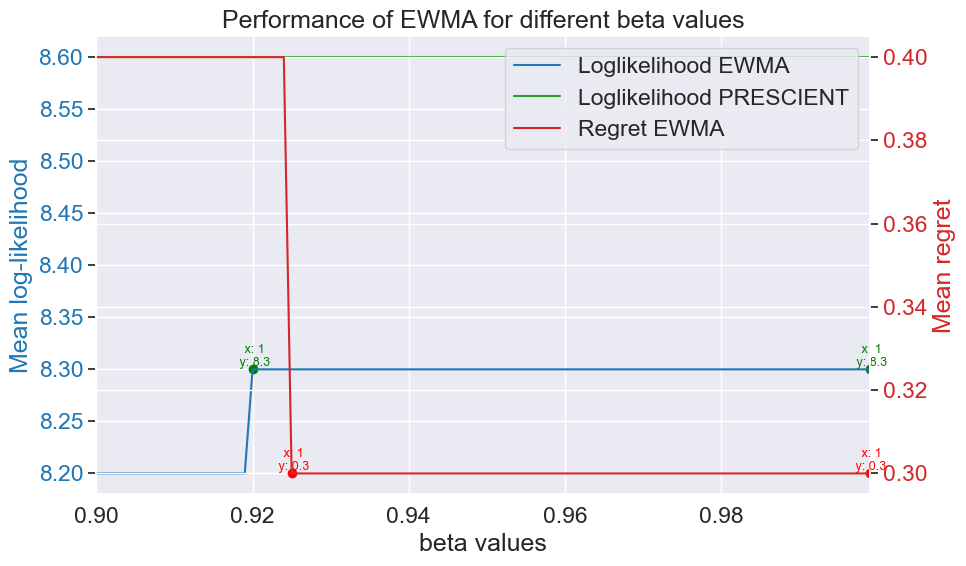

In [23]:
# skip validation phase, i already knew the best beta value
# clear the lists to make another run of the grid search
betaValues.clear()
hybridMeanRegretValues.clear()
hybridMeanlogLikelihoodValues.clear()
prescientMeanlogLikelihoodValue = 0

# this is a specific run to find the best beta value (i will search in the range 0.9 -> 1 with a step of 0.001)
betaValues, hybridMeanRegretValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = hybridPredictorValidationPhaseWithEwma(0.9, startingValidationDate, endingValidationDate, 0.001, prescientAlreadyPrinted, expandingWindowDict)

plotPerformancePredictor(betaValues, hybridMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, hybridMeanRegretValues, "EWMA", "beta")

# Test Phase for Hybrid predictor (EW + EWMA)

In [24]:
# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset
start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = predictorsConfiguration["HYBRIDEWMA_beta"]
ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(testDataWithPercentageChange, ewma_halflife))

# filter the ewmaDict dictionary by the start and end date
ewmaDict = {t: ewmaDict[t] for t in ewmaDict.keys() if t >= start_date and t <= end_date}

print("dimension of the ewma dictionary: " + str(len(ewmaDict)))


ewma_halflife used: 13.513407333964874

dimension of the ewma dictionary: 327


In [25]:
# HYBRID MODEL IMPLEMENTATION
# i have defined inside the 2 box above the expanding window and the ewma predictors; now i will use them to implement the hybrid model

# the hybrid model is a combination of the expanding window and the ewma predictors; the lambda parameter is incremented linearly in each quarter. so it is like the inverse of the number of days in a quarter

hybridModelDict = hybridPredictor(stocksPercentageChangeReturn, testDataWithPercentageChange, expandingWindowDict, ewmaDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))

print("first 3 elements of the hybrid model dictionary: ")
for key in list(hybridModelDict.keys())[:3]:
    print(key, hybridModelDict[key])    

dimension of the hybrid model dictionary: 327
first 3 elements of the hybrid model dictionary: 
2021-09-15 00:00:00           7         20990     21177
7      0.000038  0.000044 -0.000004
20990  0.000044  0.000052 -0.000004
21177 -0.000004 -0.000004  0.000000
2021-09-16 00:00:00           7         20990     21177
7      0.000033  0.000025 -0.000005
20990  0.000025  0.000047 -0.000024
21177 -0.000005 -0.000024  0.000047
2021-09-17 00:00:00           7         20990     21177
7      0.000137  0.000064  0.000019
20990  0.000064  0.000063 -0.000003
21177  0.000019 -0.000003  0.000039


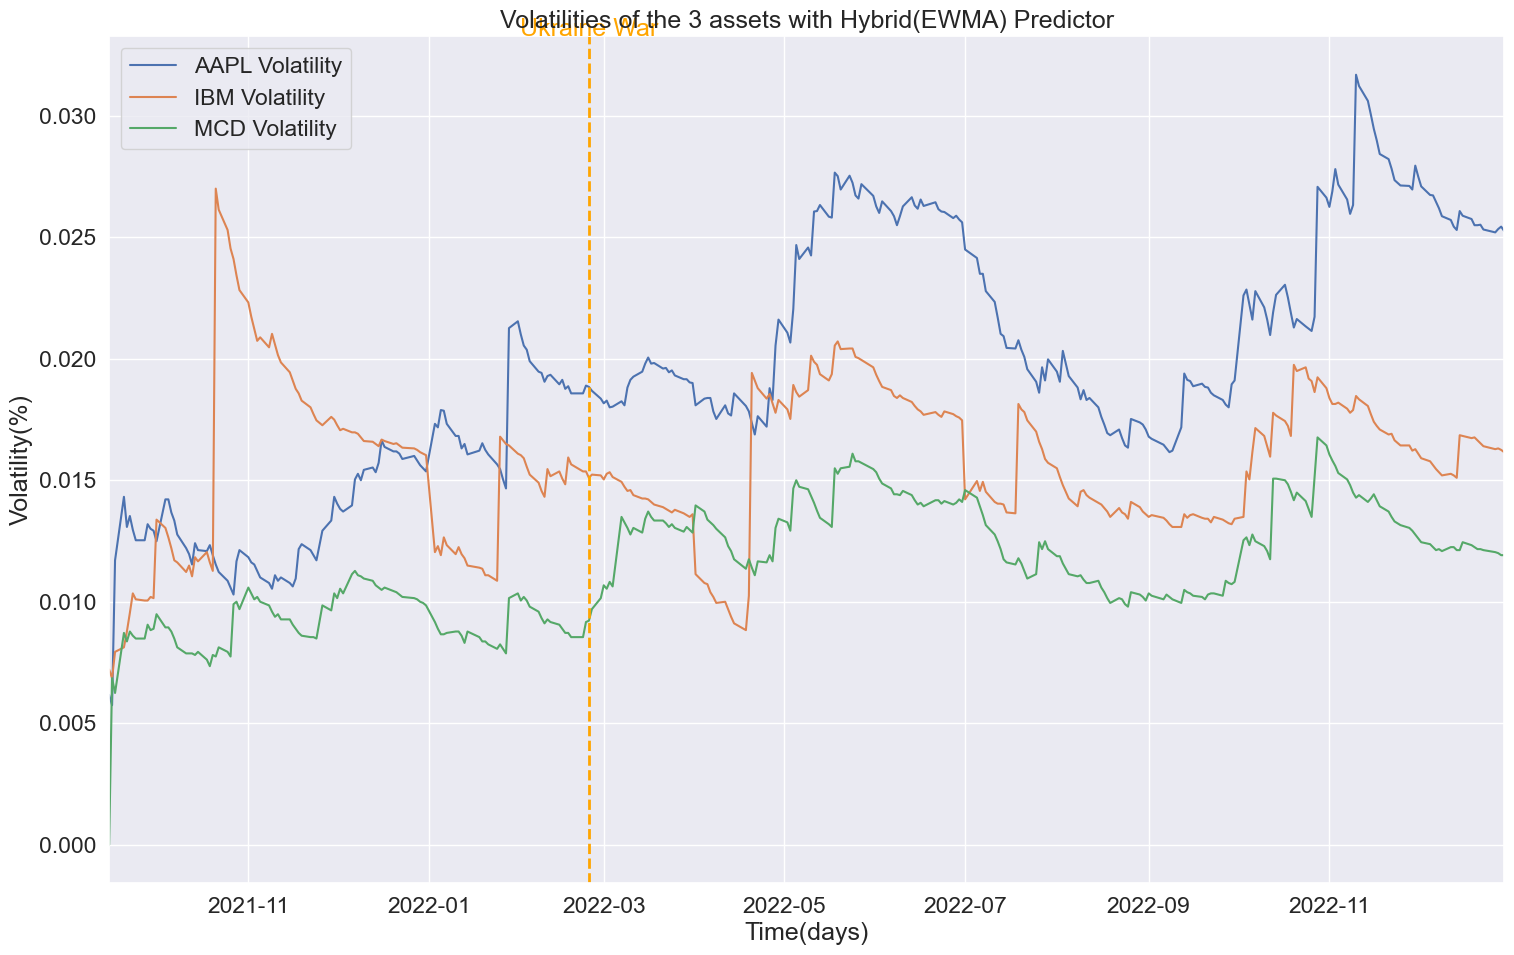

In [26]:
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(EWMA)')

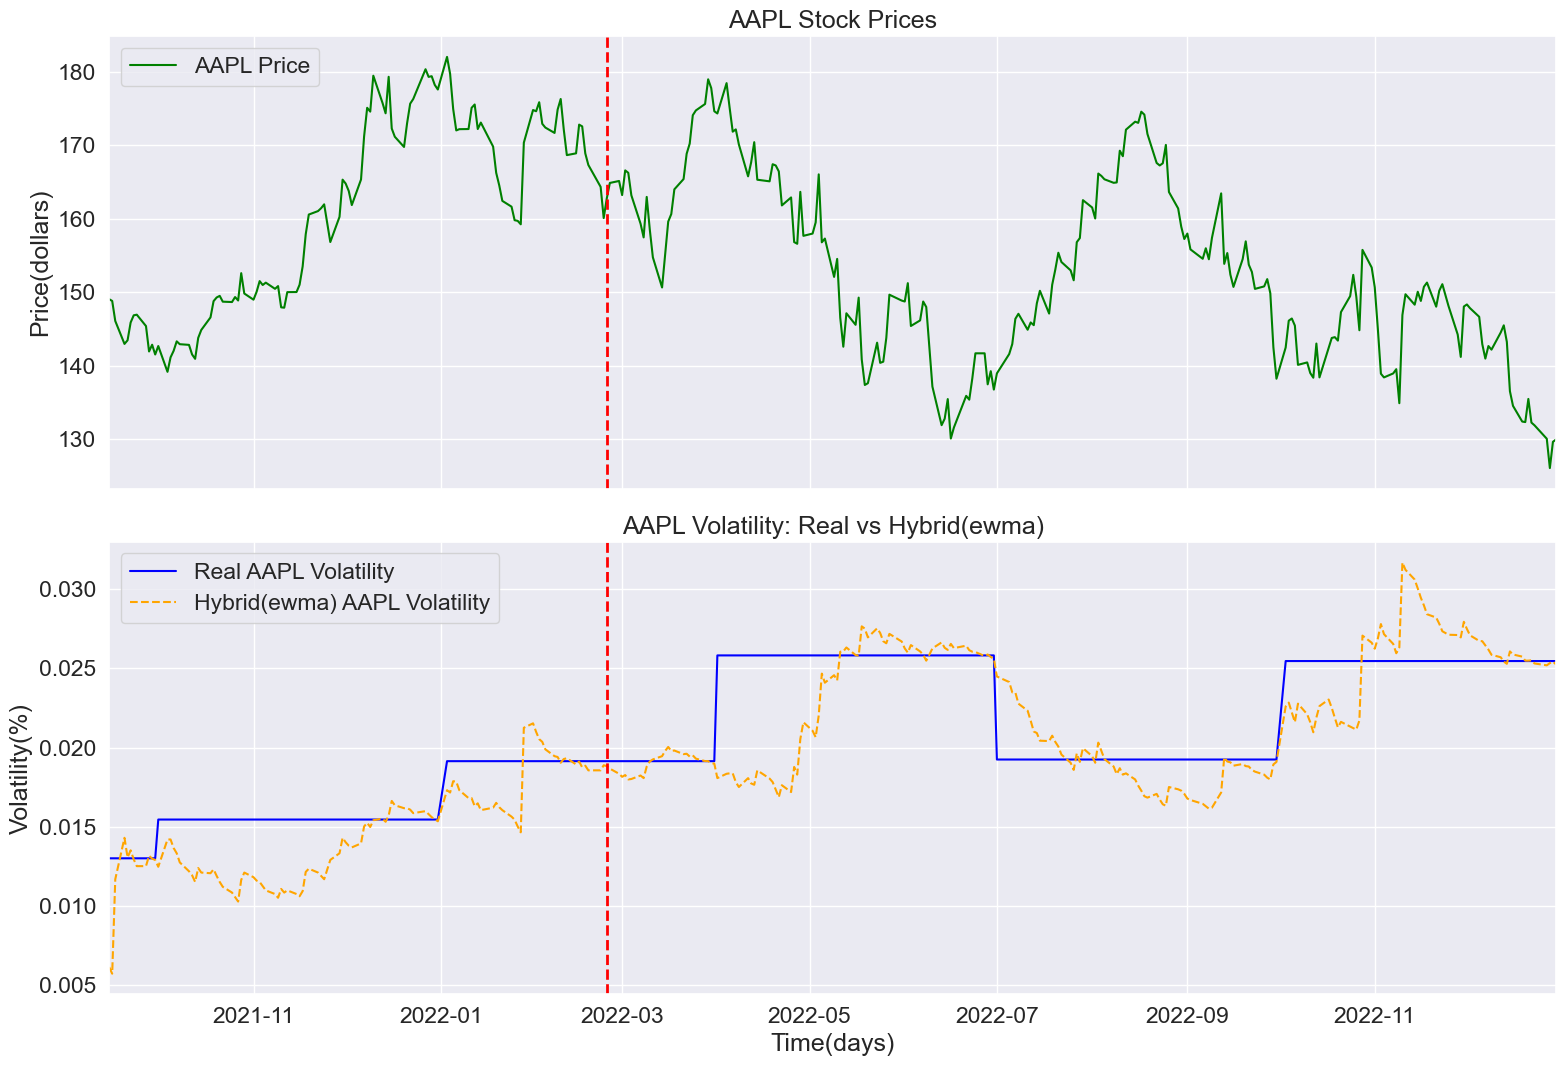

In [27]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL', "Hybrid(ewma)")

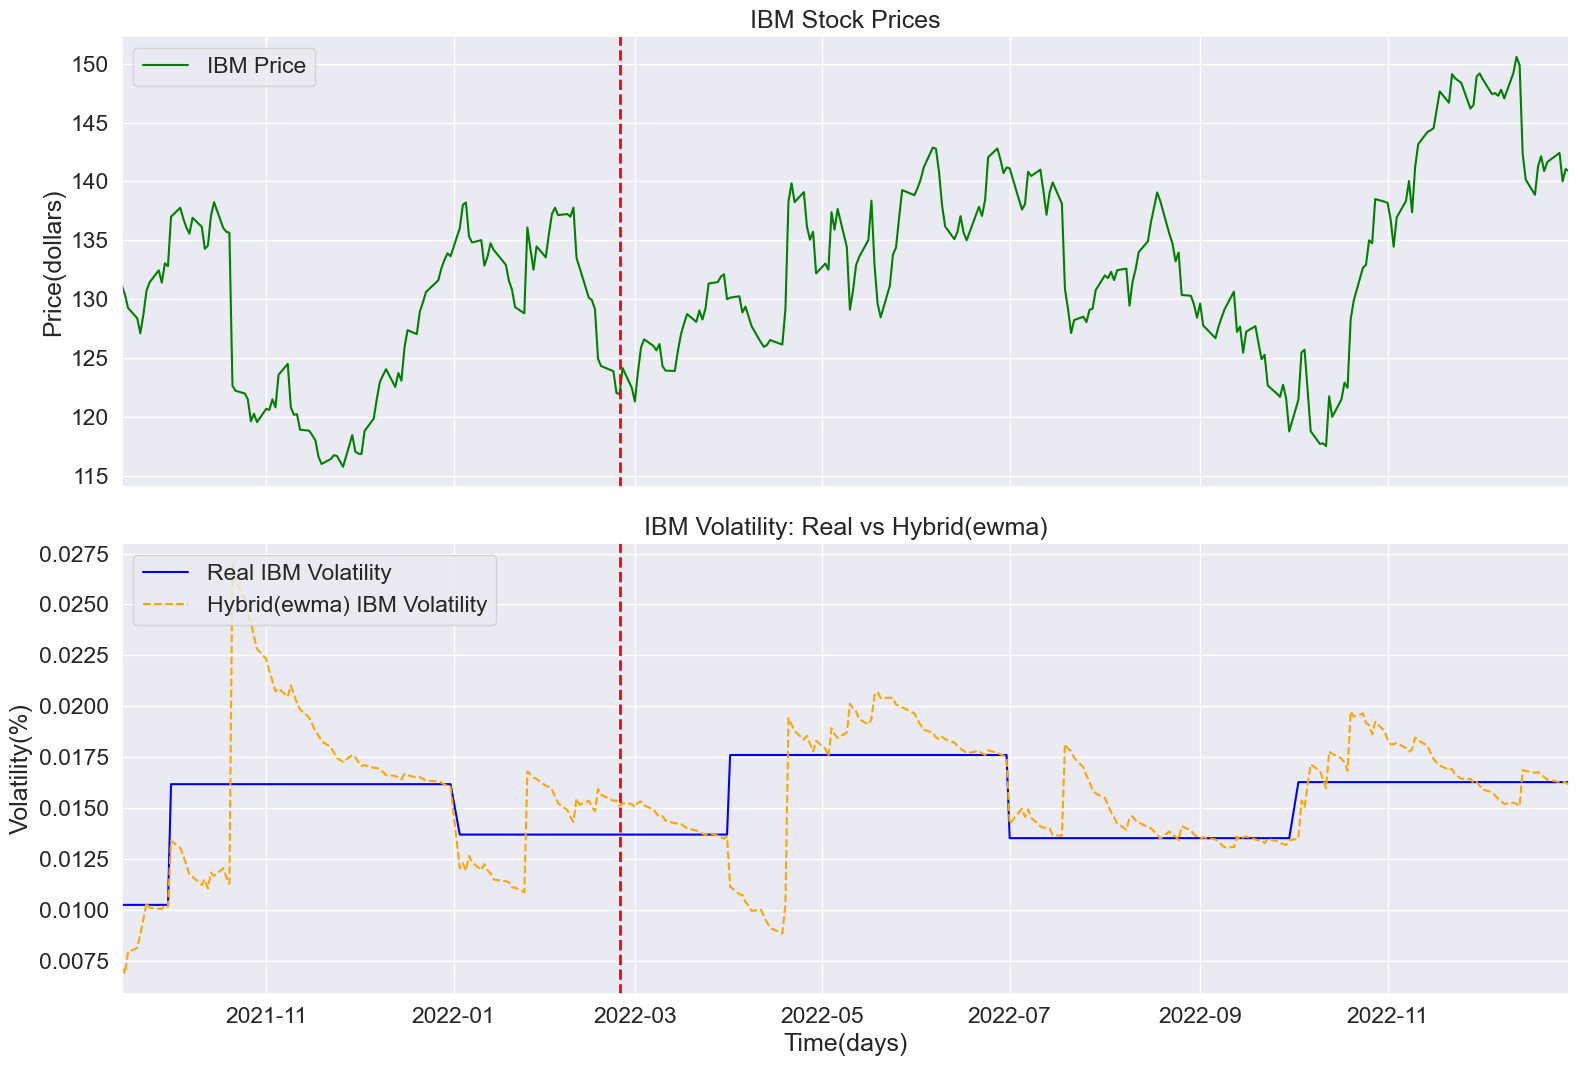

In [28]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_ibm['IBM Volatility'], 'IBM', "Hybrid(ewma)")

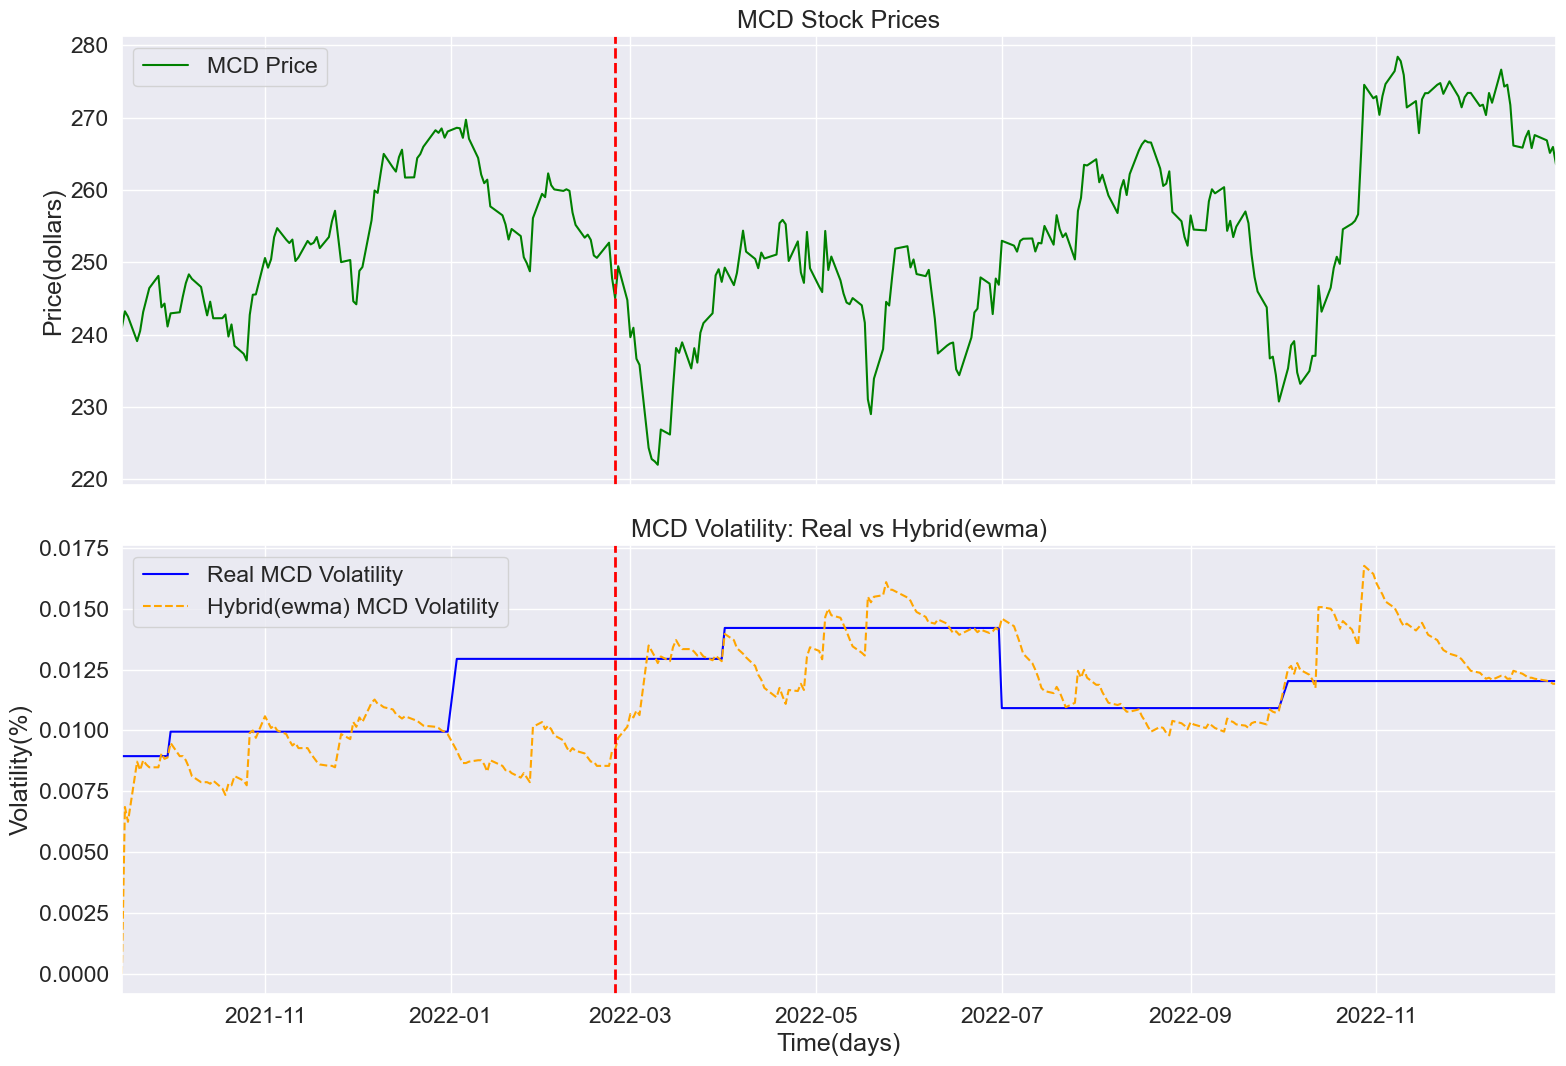

In [29]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_mcd['MCD Volatility'], 'MCD', "Hybrid(ewma)")

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


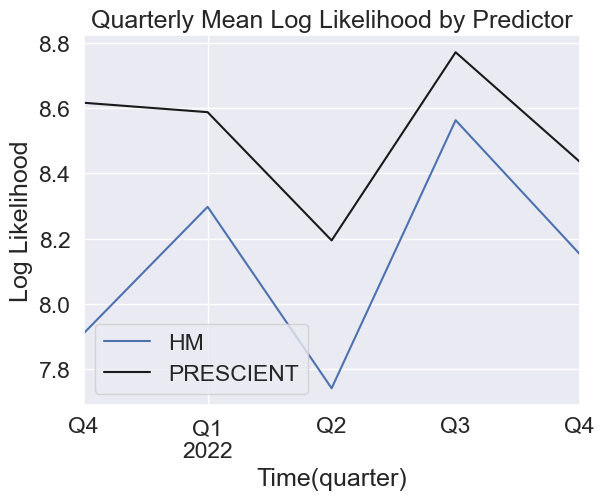



meanRegret: 0.400
stdRegret: 0.200
maxRegret: 0.700


meanLoglikelihoodHM: 8.100
stdLoglikelihoodHM: 0.300
maxLoglikelihoodHM: 8.600


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800
lenght of prescientDict:  3272
lenght of hybridDict:  327
lenght of predictorDict:  308

HM RMSE
mean: 0.0136928594
std: 0.0018395069
max: 0.0169915588
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.013191765297148344, Timestamp('2022-03-31 00:00:00'): 0.012275719657737421, Timestamp('2022-06-30 00:00:00'): 0.016991558793600942, Timestamp('2022-10-02 00:00:00'): 0.011814079823440642, Timestamp('2022-12-29 00:00:00'): 0.014191173262827813}


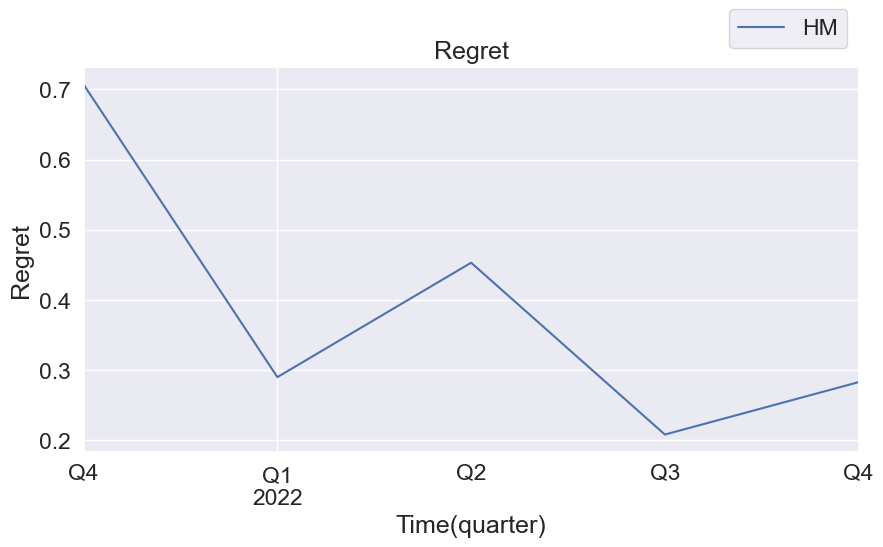

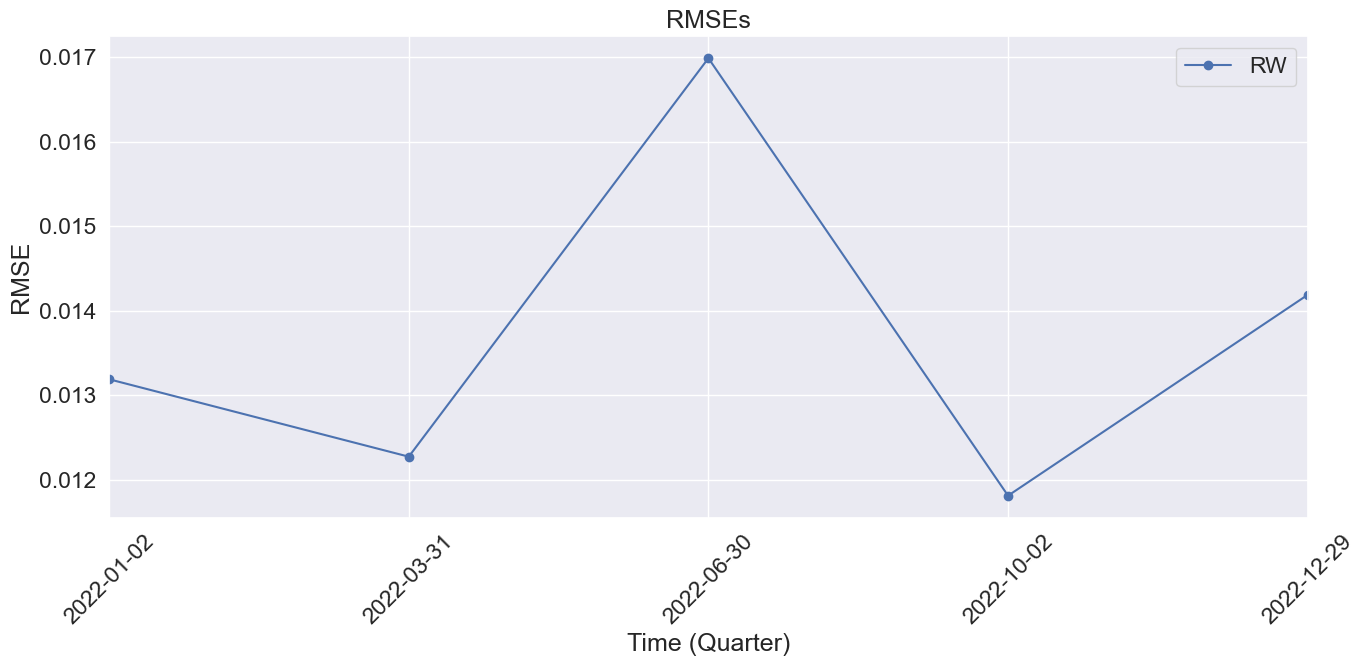

lenght of volatility_dict_aapl:  308
lenght of volatility_dict_aaapl_hybrid:  308
lenght of RMSEs_aapl:  5
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.054218856156201534, Timestamp('2022-03-31 00:00:00'): 0.040992520661416926, Timestamp('2022-06-30 00:00:00'): 0.06720804161746832, Timestamp('2022-10-02 00:00:00'): 0.044619332298639895, Timestamp('2022-12-29 00:00:00'): 0.0519352448384986}


RMSEs for AAPL
mean: 0.0517947991
std: 0.0090734819
max: 0.0672080416


RMSEs for IBM
mean: 0.0478980939
std: 0.0108757528
max: 0.0622674241


RMSEs for MCD
mean: 0.0407699968
std: 0.0089361600
max: 0.0568192633


In [30]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 0(hybrid dict)
hybridDict = predictors[0]
hybridDict = {k: hybridDict[k] for k in list(hybridDict)[19:]}
predictors[0] = hybridDict

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Regret')  # Set the y-axis label
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        hybridMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of hybridDict: ", len(hybridModelDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}

volatility_dict_aapl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_mcd.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_hybrid: ", len(volatility_dict_aapl_hybrid_filtered))

# get the rmse of single assets. i take just aapl, ibm and mcd
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_hybrid_filtered, volatility_dict_ibm_hybrid_filtered, volatility_dict_mcd_hybrid_filtered, start_date)

Now here i store all the variables that i need to pass to other notebooks.

In [31]:
# create a dictionary for the volatilities of the prescient predictor
hybrid_ewma_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
hybrid_ewma_volatilities["AAPL"] = volatility_dict_aapl_hybrid_filtered
hybrid_ewma_volatilities["IBM"] = volatility_dict_ibm_hybrid_filtered
hybrid_ewma_volatilities["MCD"] = volatility_dict_mcd_hybrid_filtered

# store the dictionary
%store hybrid_ewma_volatilities

Stored 'hybrid_ewma_volatilities' (dict)


# HYBRID VS NORMAL PREDICTOR PERFORMANCE COMPARISON (EWMA)

size of the first predictor: 308
size of the second predictor: 308
size of the third predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00
first timestamp of the third predictor: 2021-10-12 00:00:00


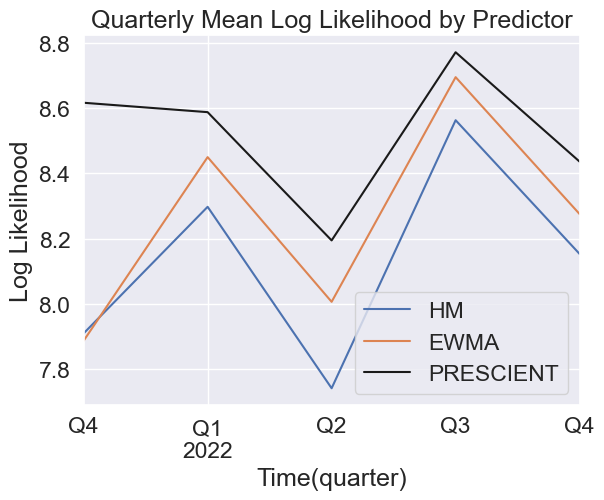



meanRegret: 0.300
stdRegret: 0.200
maxRegret: 0.700


meanLoglikelihoodHM: 8.100
stdLoglikelihoodHM: 0.300
maxLoglikelihoodHM: 8.600


meanLoglikelihoodEWMA: 8.300
stdLoglikelihoodEWMA: 0.300
maxLoglikelihoodEWMA: 8.700


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800


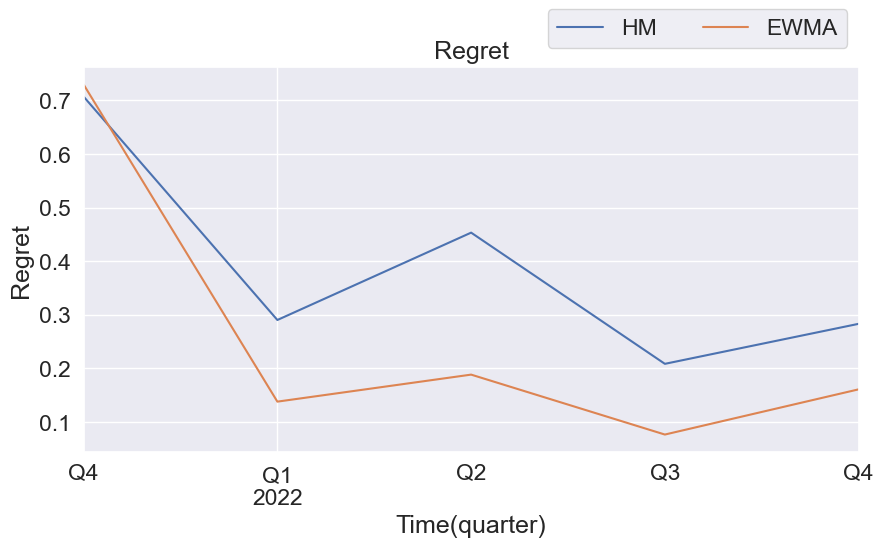

In [32]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "EWMA", "PRESCIENT"]
beta = 0.9870000000000001
ewma_halflife = -np.log(2) / np.log(beta)

ewmaDict = dict(_ewma_cov(testDataWithPercentageChange, halflife=ewma_halflife))

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, ewmaDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 0(hybrid dict)
hybridDictionary = predictors[0]
hybridDictionary = {k: hybridDictionary[k] for k in list(hybridDictionary)[19:]}
predictors[0] = hybridDictionary

# now remove the first 19 entries from the predictor 0(hybrid dict)
ewmaDictionary = predictors[1]
ewmaDictionary = {k: ewmaDictionary[k] for k in list(ewmaDictionary)[19:]}
predictors[1] = ewmaDictionary

# now remove the first 19 entries from the predictor 0(hybrid dict)
prescentDictionary = predictors[2]
prescentDictionary = {k: prescentDictionary[k] for k in list(prescentDictionary)[19:]}
predictors[2] = prescentDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))
print("size of the third predictor: " + str(len(predictors[2])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])
assert len(predictors[0]) == len(predictors[2])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()
assert predictors[0].keys() == predictors[2].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))
print("first timestamp of the third predictor: " + str(list(predictors[2].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Regret')  # Set the y-axis label
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        hybridMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")

# Validation Phase for Hybrid predictor (EW + MGARCH)

In [33]:
def modify_env_variable(env_file_path, variable_to_modify, new_value):
    '''
    code to modify the value of a specific variable in a .env file
    '''
    # Read the .env file
    with open(env_file_path, 'r') as file:
        lines = file.readlines()
    
    # Modify the specific variable
    modified_lines = []
    variable_found = False
    for line in lines:
        if line.startswith(variable_to_modify):
            modified_lines.append(f"{variable_to_modify}={new_value}\n")
            variable_found = True
        else:
            modified_lines.append(line)
    
    # If the variable was not found, add it to the file
    if not variable_found:
        modified_lines.append(f"{variable_to_modify}={new_value}\n")
    
    # Write the modified content back to the .env file
    with open(env_file_path, 'w') as file:
        file.writelines(modified_lines)

In [34]:
from mgarchAnalysis.flattenCovMatrices import *

def callRprocessAndUpdateCSVfile(csv_file_path, r_file_path):
    '''
    Function to call the R process and update the csv validation file
    '''

    # modify the environment variable USE_HYBRID_MGARCH to true
    modify_env_variable(file_path_first_part + 'experiments/.env', 'USE_HYBRID_MGARCH', 'true')

    csv_file_path = file_path_first_part + csv_file_path
    # Define the path to your R script
    r_script_path = file_path_first_part + r_file_path 

    # Define the command to run your R script
    command = ['Rscript', r_script_path]

    returnCode = 1

    while returnCode != 0:
        
        # Execute the command
        result = subprocess.run(command, capture_output=True, text=True)
        # if the code fails there is a problem of convergence so i keep trying to run the R script until it converges
        # Check if there was an error and raise an exception if so
        if result.returncode != 0:
            print("Error running the R script:")
            print(result.stderr)
        else:
            # If no error, print the output
            print("R script executed successfully:")
            print(result.stdout)
            returnCode = 0

    # Update the csv file with the validation results
    flattenAllMatrices(csv_file_path)

In [35]:
# MGARCH precomputed in R due to computational complexity
# now to automatize the process of obtaining the MGARCH predictions, i will call a function that will execute the r script that calculates the MGARCH predictions
# so the csv is updated with the MGARCH predictions and then i will read the csv file to obtain the MGARCH predictions
'''
callRprocessAndUpdateCSVfile("AllCovMatricesForValidation.csv", 'experiments/mgarchAnalysis/dccGarchTraningValidationTuning.r')

# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
testSetLength = len(testDataWithPercentageChange)
times = stocksPercentageChangeReturn.loc[validation_start_date:validation_end_date].index

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print
'''

'\ncallRprocessAndUpdateCSVfile("AllCovMatricesForValidation.csv", \'experiments/mgarchAnalysis/dccGarchTraningValidationTuning.r\')\n\n# The covariance matrices were computed for 100*r for numerical reasons \n\nmgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForValidation.csv", index_col=None)\n\n# here we are obtaining the covariance matrix calculated for every day from the csv file;\n# so this covariance matrix estimation is done with real returns and not with interpolated returns\nSigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio\n\nprint("sigma shape:", Sigmas.shape)\n# Remove the training dataset \ntrainingSetLength = len(trainingDataWithPercentageChange)\ntestSetLength = len(testDataWithPercentageChange)\ntimes = stocksPercentageChangeReturn.loc[validat

In [36]:
# now see how well the mgarch predictor is doing in predicting the real volatilities of the 3 assets by calculating the log-likelihood and the regret and mse

start_date = pd.to_datetime(startingValidationDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingValidationDate, format="%Y-%m-%d")

In [37]:
# now i get the covariance matrixes of the hybrid predictor using expanding window and mgarch
'''
hybridModelDict =  hybridPredictor(stocksPercentageChangeReturn, validationDataWithPercentageChange, expandingWindowDict, mgarchDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))

print("first 3 elements of the hybrid model dictionary: ")
for key in list(hybridModelDict.keys())[:3]:
    print(key, hybridModelDict[key])
'''

'\nhybridModelDict =  hybridPredictor(stocksPercentageChangeReturn, validationDataWithPercentageChange, expandingWindowDict, mgarchDict, start_date, increment_type, k)\n\nprint("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))\n\nprint("first 3 elements of the hybrid model dictionary: ")\nfor key in list(hybridModelDict.keys())[:3]:\n    print(key, hybridModelDict[key])\n'

In [38]:
'''
names = ["HYBRID", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# metrics to evaluate during the validation period: log-likelihood, regret, and MSE
'''
'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''
'''
print("length of hybrid predictor: ", len(predictors[0]))
print("length of prescient predictor: ", len(predictors[1]))

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


# Iterate through each predictor in the log_likelihoods dictionary
for name in daily_log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        daily_log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        daily_log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot
'''

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
'''
for name in daily_log_likelihoods:
    daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        daily_regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Regret')  # Set the y-axis label
plt.title("Regret")


for name in daily_regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
daily_log_likelihoods_copy = daily_log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in daily_log_likelihoods_copy:
    quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")
'''

'\nfor name in daily_log_likelihoods:\n    daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]\n\n\nfig, ax = plt.subplots(1, 1, figsize=(10, 5))\nfor name in names:\n    if name == \'PRESCIENT\':\n        pass\n    else:\n        daily_regrets[name].resample("Q").mean().plot(label=name)\nplt.legend(bbox_to_anchor=(0.5, 1.1), loc=\'center\', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);\nplt.xlabel(\'Time(quarter)\')  # Set the x-axis label\nplt.ylabel(\'Regret\')  # Set the y-axis label\nplt.title("Regret")\n\n\nfor name in daily_regrets:\n    if name != "PRESCIENT":\n\n        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.\n        quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, 

In [39]:
'''
startingValidationDate = validationDataWithPrices.index[0].strftime("%Y-%m-%d")
endingValidationDate = validationDataWithPrices.index[-1].strftime("%Y-%m-%d")

# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingValidationDate)
real_volatility_endDate = pd.to_datetime(endingValidationDate)

df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(MGARCH)')
'''

'\nstartingValidationDate = validationDataWithPrices.index[0].strftime("%Y-%m-%d")\nendingValidationDate = validationDataWithPrices.index[-1].strftime("%Y-%m-%d")\n\n# now filter the rw volatilities between the start and end date\nreal_volatility_startDate = pd.to_datetime(startingValidationDate)\nreal_volatility_endDate = pd.to_datetime(endingValidationDate)\n\ndf_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, \'Hybrid(MGARCH)\')\n'

In [40]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE MGARCH PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

#plot_prices_volatilities_for_predictor(validationDataWithPrices, df_volatility_aapl["AAPL Volatility"], startDateFilter, endDateFilter, df_volatility_aapl_hybrid['AAPL Volatility'], 'AAPL', "hybrid(mgarch)")

# Test Phase for Hybrid predictor (EW + MGARCH)

In [41]:
# MGARCH precomputed in R due to computational complexity
# now to automatize the process of obtaining the MGARCH predictions, i will call a function that will execute the r script that calculates the MGARCH predictions
# so the csv is updated with the MGARCH predictions and then i will read the csv file to obtain the MGARCH predictions

callRprocessAndUpdateCSVfile("AllCovMatricesForTesting.csv", "experiments/mgarchAnalysis/dccGarchTrainValidationTest.r")

# read from this file the covariance matrices calculated for the test phase
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/FlattenedAllCovMatricesForTesting.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

print("sigma shape:", Sigmas.shape)
# Remove the training dataset 
trainingSetLength = len(trainingDataWithPercentageChange)
validationSetLength = len(validationDataWithPercentageChange)
times = stocksPercentageChangeReturn.index[trainingSetLength + validationSetLength:]

print("len of times: ", len(times))

mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])}

print("mgarchDict len:", len(mgarchDict))
# calculate the covariance matrix for the test phase

# print just the first key and value of the dictionary
print(list(mgarchDict.keys())[0]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(mgarchDict.keys())[-1]) # TODO: delete this print
print(mgarchDict[list(mgarchDict.keys())[-1]]) # TODO: delete this print

R script executed successfully:
[1] "TRAIN AND TEST RUN"

Model order: 3 
Training data size: 2291 
Validation data size: 654 
Testing data size: 327 
Length  Class   Mode 
     1 DCCfit     S4 

*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(3,3)
No. Parameters       :  33
[VAR GARCH DCC UncQ] : [0+24+6+3]
No. Series           :  3
No. Obs.             :  2290
Log-Likelihood       :  20829.02
Av.Log-Likelihood    :  9.1 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error  t value Pr(>|t|)
[AAPL].mu      0.001326    0.000350 3.786956 0.000153
[AAPL].omega   0.000035    0.000020 1.738254 0.082166
[AAPL].alpha1  0.152199    0.051442 2.958622 0.003090
[AAPL].alpha2  0.031856    0.038942 0.818027 0.413342
[AAPL].alpha3  0.008727    0.085988 0.101493 0.919159
[AAPL].beta1   0.000079    0.223685 0.000352 0.999719
[AAPL].beta2   0.64

In [42]:
# calculate the hybrid predictor covariance matrix for the test phase

hybridModelDict = hybridPredictor(stocksPercentageChangeReturn, testDataWithPercentageChange, expandingWindowDict, mgarchDict, start_date, increment_type, k)

print("dimension of the hybrid model dictionary: " + str(len(hybridModelDict)))

# print the first and the last element of the dictionary
print(list(hybridModelDict.keys())[0]) # TODO: delete this print
print(hybridModelDict[list(hybridModelDict.keys())[0]]) # TODO: delete this print
print("\n")
print(list(hybridModelDict.keys())[-1]) # TODO: delete this print
print(hybridModelDict[list(hybridModelDict.keys())[-1]]) # TODO: delete this print

dimension of the hybrid model dictionary: 327
2021-09-15 00:00:00
          7         20990     21177
7      0.000303  0.000065  0.000026
20990  0.000065  0.000131  0.000036
21177  0.000026  0.000036  0.000069


2022-12-30 00:00:00
          7         20990     21177
7      0.000638  0.000281  0.000109
20990  0.000281  0.000261  0.000097
21177  0.000109  0.000097  0.000142


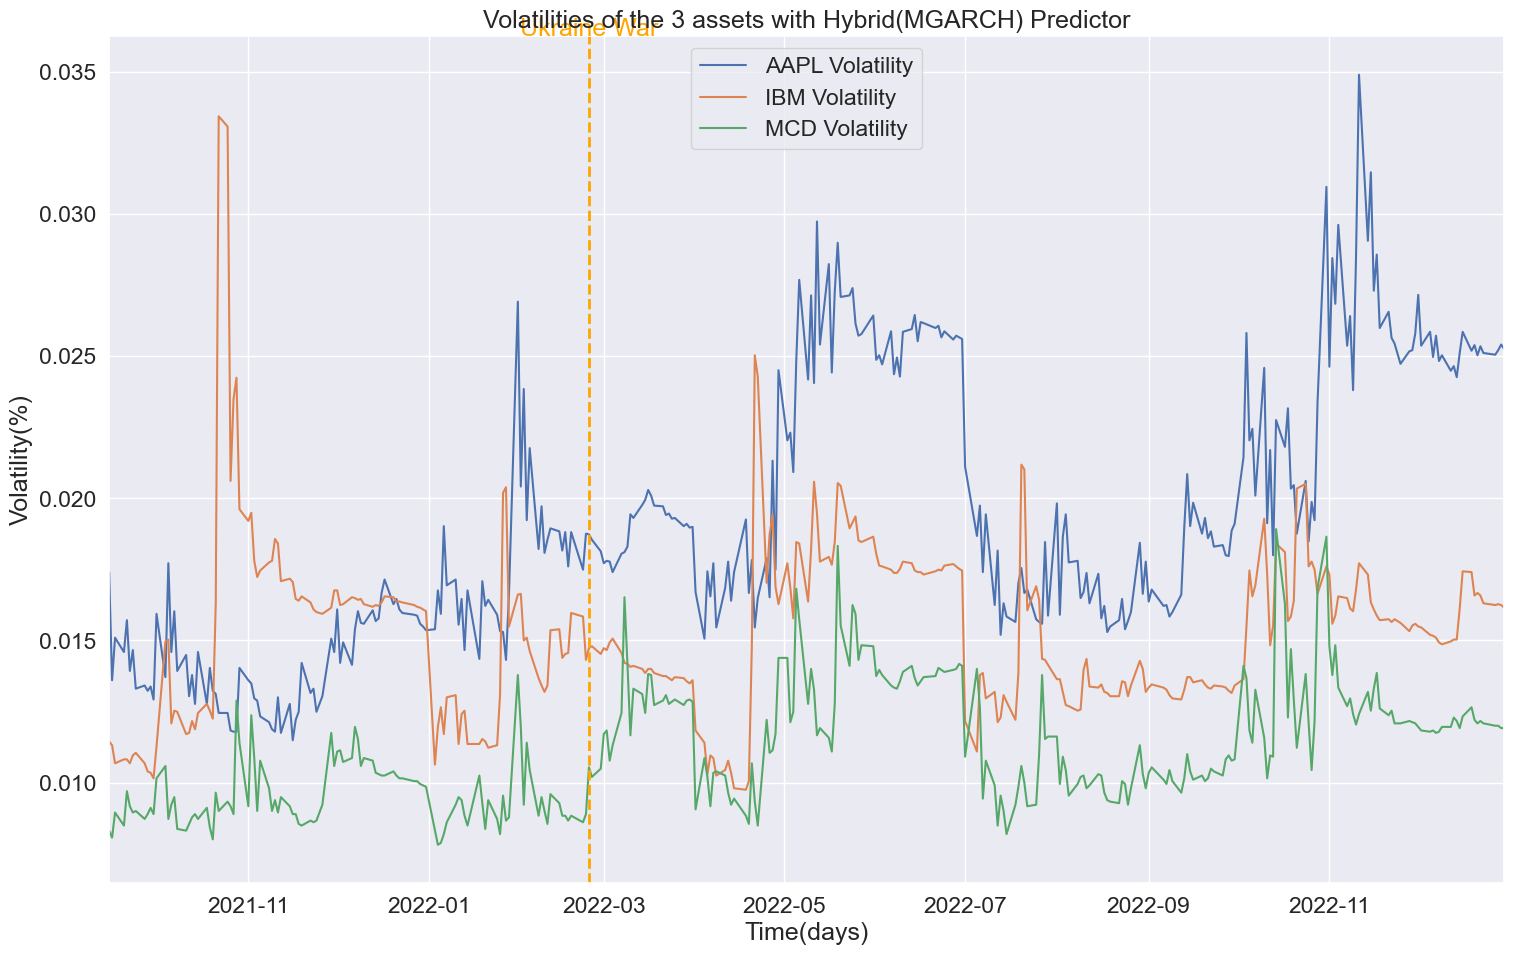

In [43]:
# now filter the rw volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

df_hybrid_volatility_aapl, df_hybrid_volatility_ibm, df_hybrid_volatility_mcd, hybrid_volatility_dict_aapl, hybrid_volatility_dict_ibm, hybrid_volatility_dict_mcd = plot_volatility(hybridModelDict, real_volatility_startDate, real_volatility_endDate, 'Hybrid(MGARCH)')

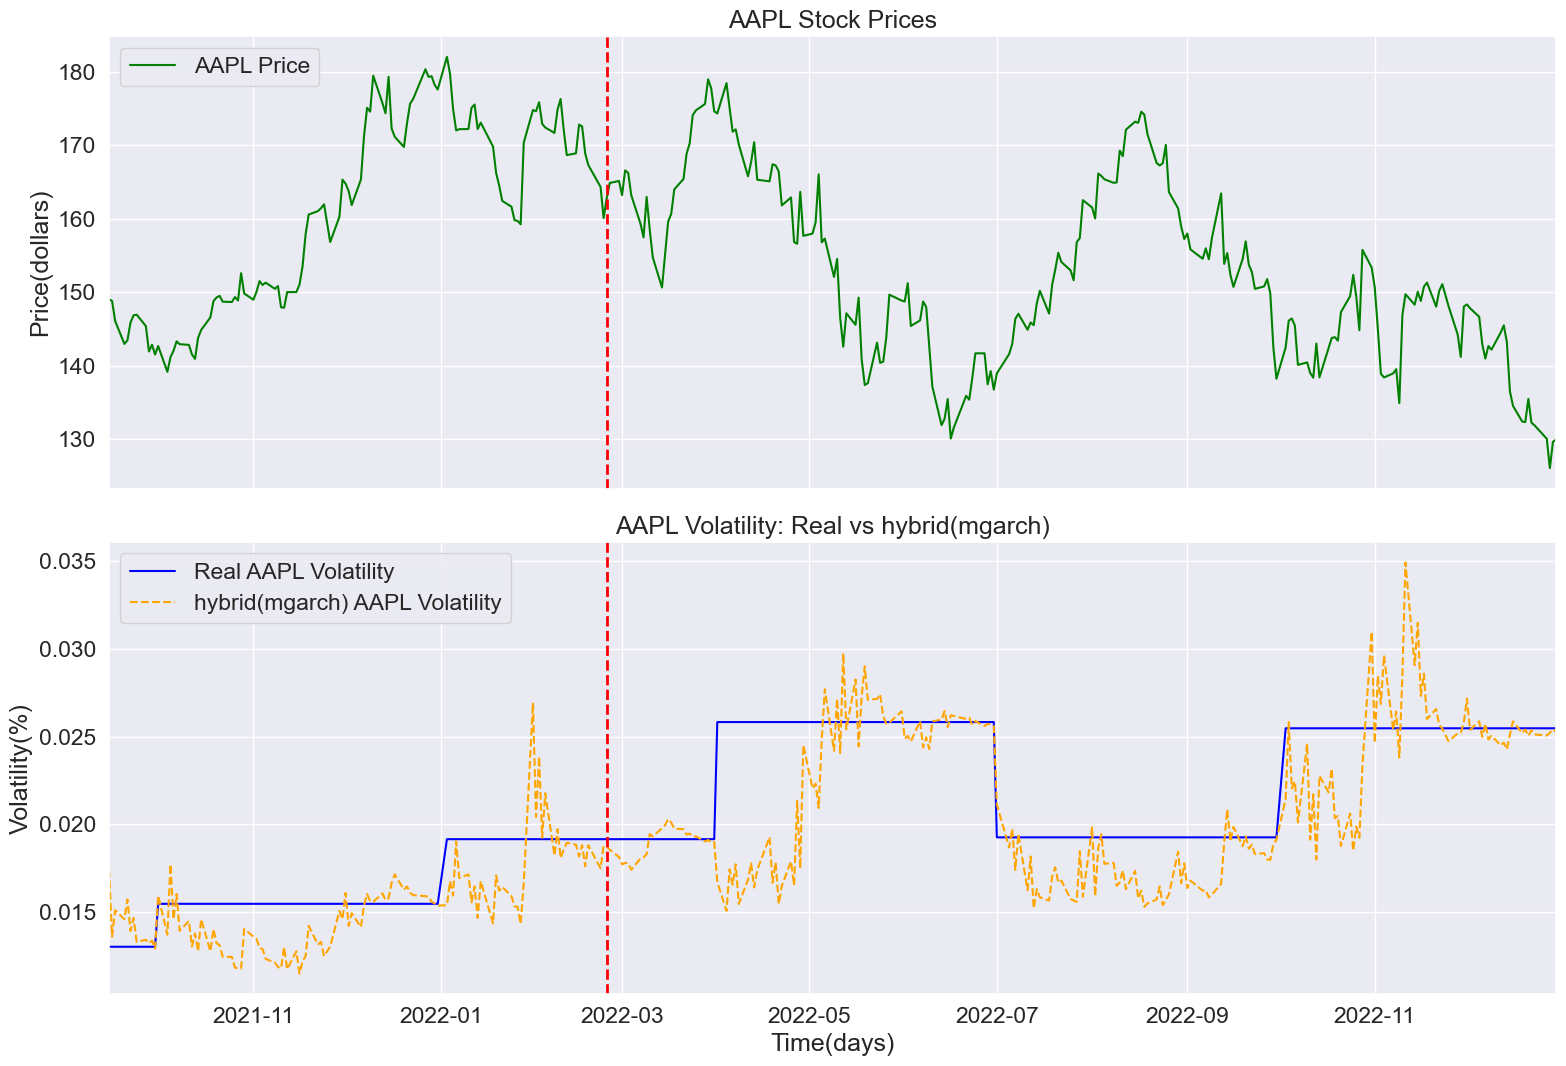

In [44]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'],startDateFilter, endDateFilter, df_hybrid_volatility_aapl['AAPL Volatility'], 'AAPL', "hybrid(mgarch)")

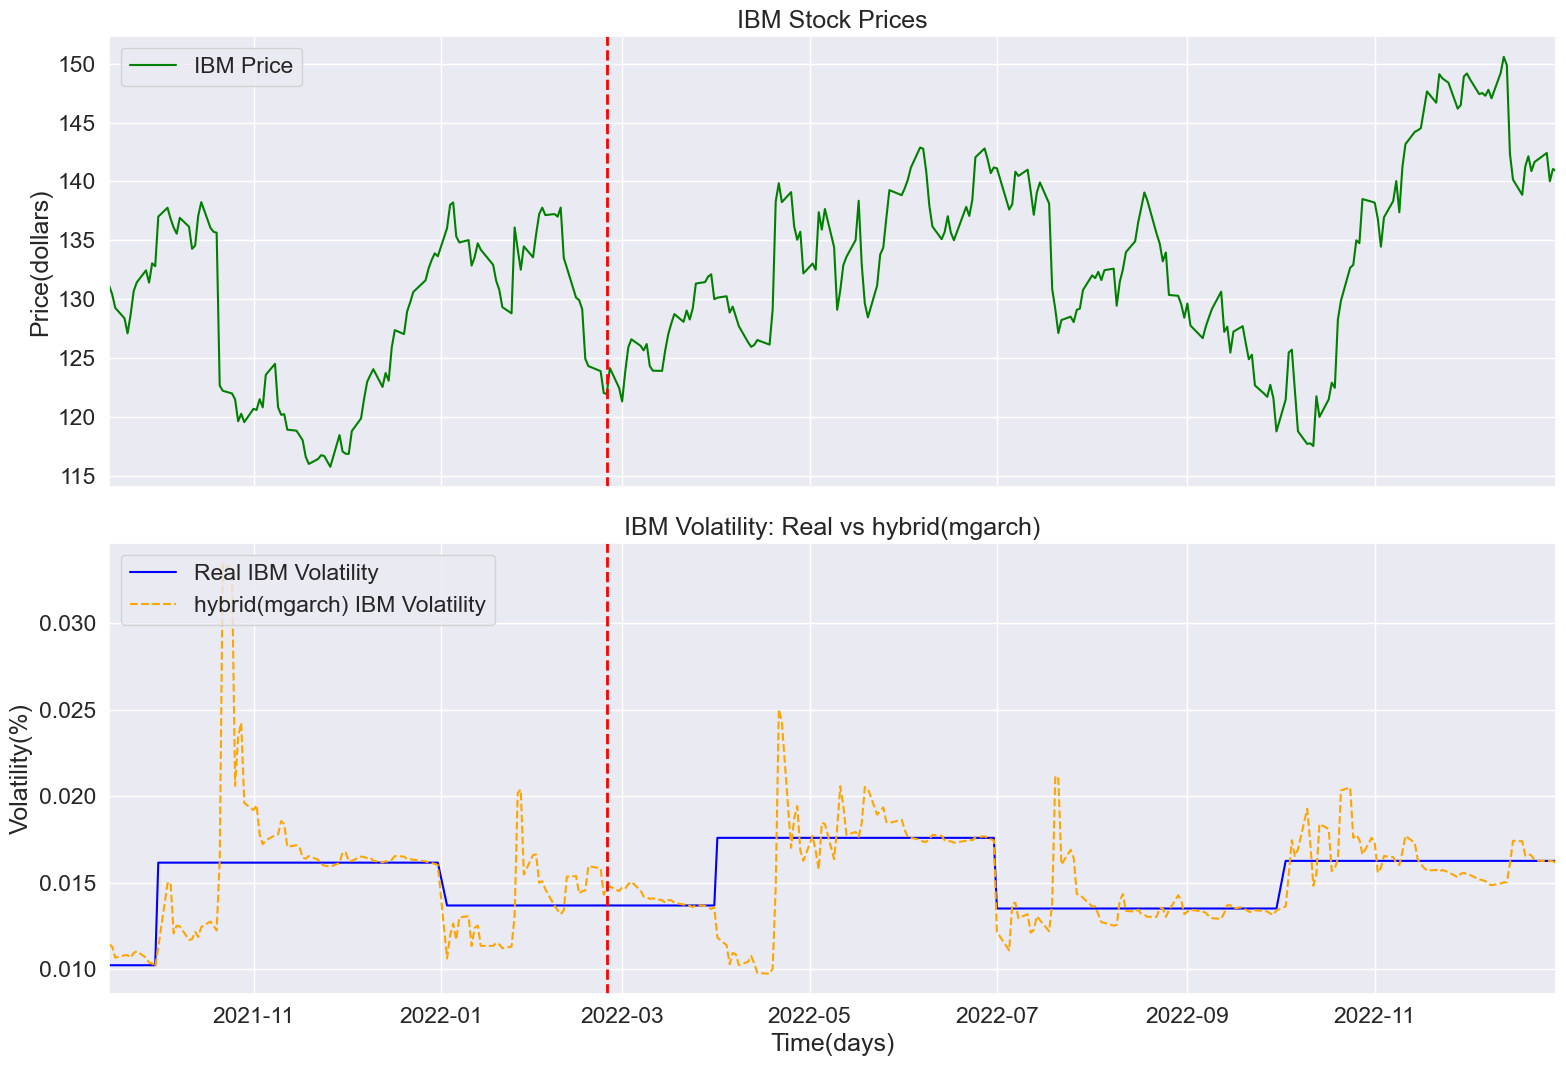

In [45]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_ibm['IBM Volatility'], 'IBM', "hybrid(mgarch)")

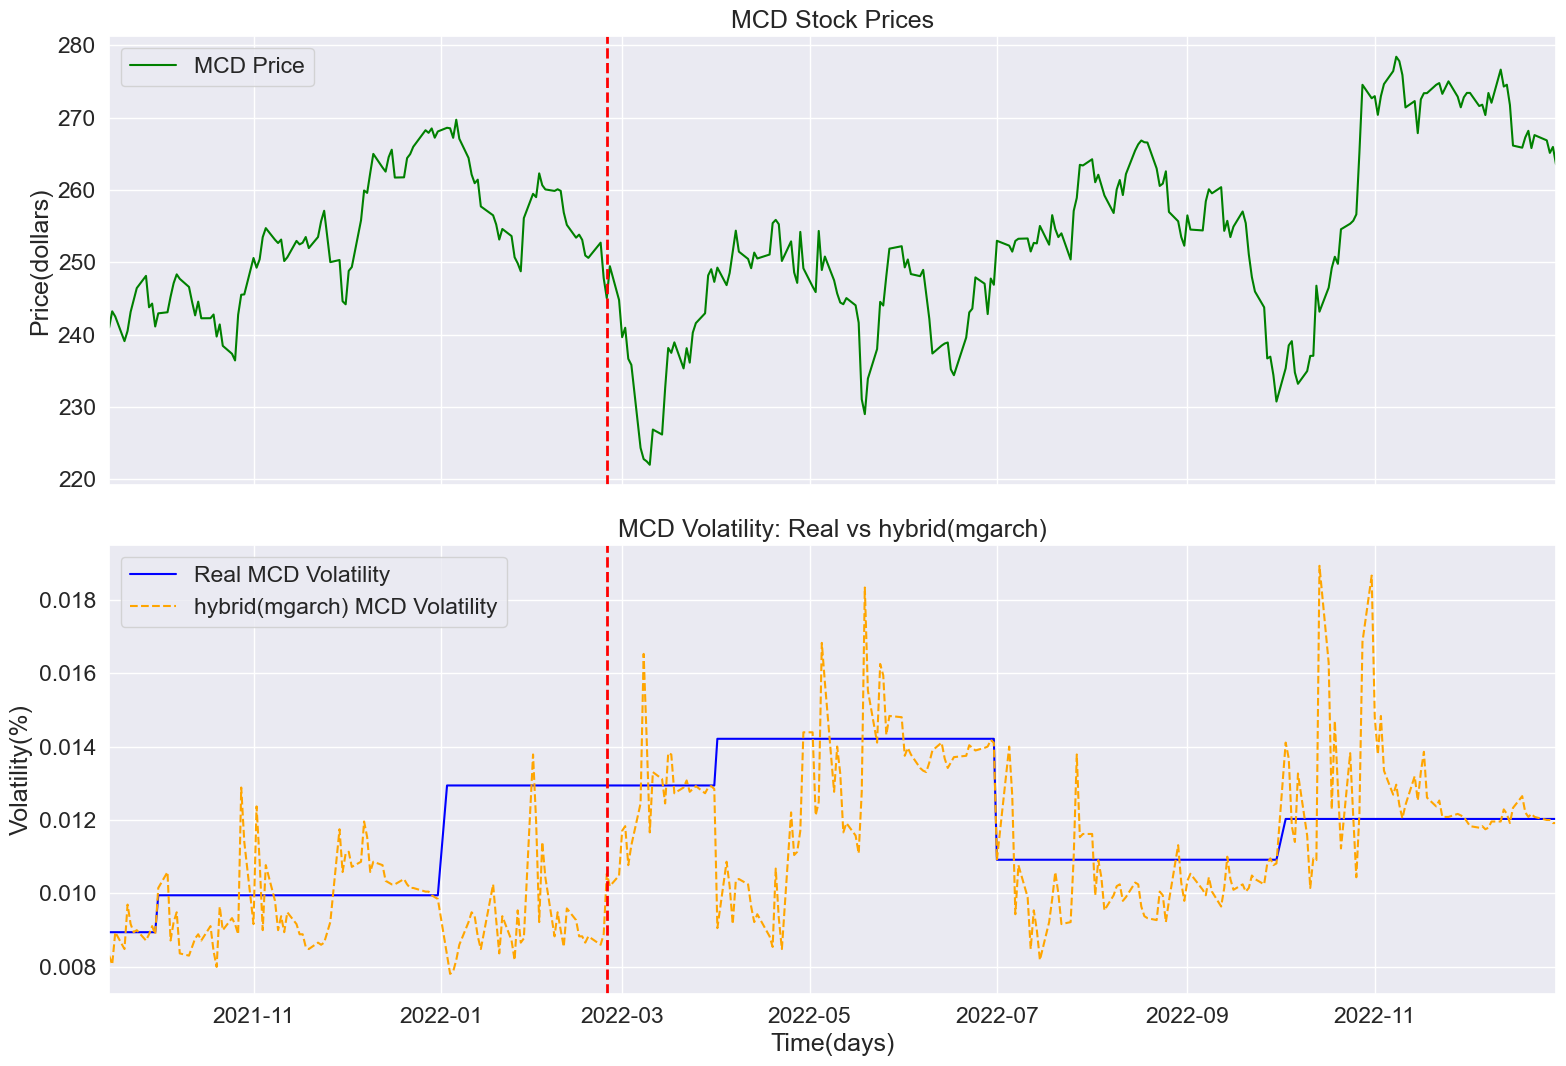

In [46]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_hybrid_volatility_mcd['MCD Volatility'], 'MCD', "hybrid(mgarch)")

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


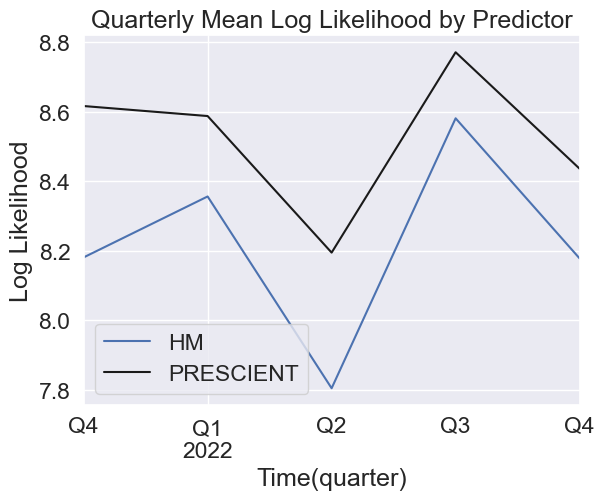



meanRegret: 0.300
stdRegret: 0.100
maxRegret: 0.400


meanLoglikelihoodHM: 8.200
stdLoglikelihoodHM: 0.300
maxLoglikelihoodHM: 8.600


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800
lenght of prescientDict:  3272
lenght of hybridDict:  327
lenght of predictorDict:  308

HM RMSE
mean: 0.0141520314
std: 0.0021874407
max: 0.0181677608
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.013516032499867273, Timestamp('2022-03-31 00:00:00'): 0.012527998707052998, Timestamp('2022-06-30 00:00:00'): 0.018167760823263424, Timestamp('2022-10-02 00:00:00'): 0.012006273327965784, Timestamp('2022-12-29 00:00:00'): 0.014542091878543146}


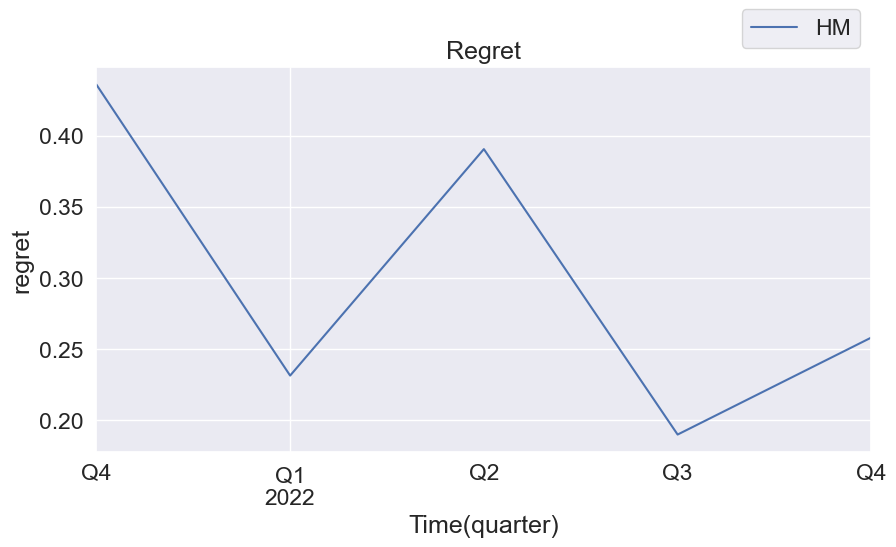

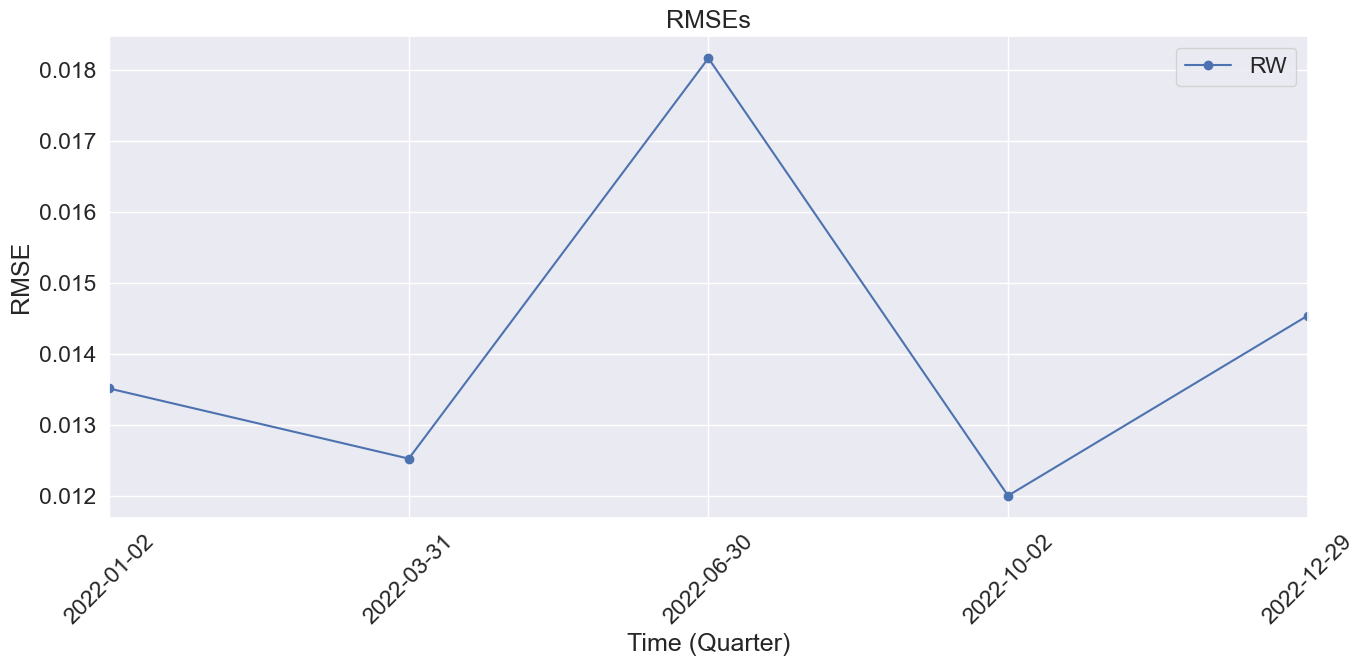

lenght of volatility_dict_aapl:  308
lenght of volatility_dict_aaapl_hybrid:  308
lenght of RMSEs_aapl:  5
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.04519644946237236, Timestamp('2022-03-31 00:00:00'): 0.04752301039829263, Timestamp('2022-06-30 00:00:00'): 0.07097299809609073, Timestamp('2022-10-02 00:00:00'): 0.04922694590184577, Timestamp('2022-12-29 00:00:00'): 0.057310163205636366}


RMSEs for AAPL
mean: 0.0540459134
std: 0.0093943094
max: 0.0709729981


RMSEs for IBM
mean: 0.0476287461
std: 0.0104804419
max: 0.0610645726


RMSEs for MCD
mean: 0.0430782617
std: 0.0092539556
max: 0.0556878056


In [47]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

hybridDictionary = predictors[0]

# now remove the first 19 entries from the predictor 0(hybrid dict)
hybridDictionary = {k: hybridDictionary[k] for k in list(hybridDictionary)[19:]}
predictors[0] = hybridDictionary

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('regret')
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        hybridMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")


#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of hybridDict: ", len(hybridModelDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}

volatility_dict_aapl_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_hybrid_filtered = {k: v for k, v in hybrid_volatility_dict_mcd.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_hybrid: ", len(volatility_dict_aapl_hybrid_filtered))
# get the rmse of single assets. i take just aapl, ibm and mcd
        
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_hybrid_filtered, volatility_dict_ibm_hybrid_filtered, volatility_dict_mcd_hybrid_filtered, start_date)

Now here i store all the variables that i need to pass to other notebooks.

In [48]:
# create a dictionary for the volatilities of the prescient predictor
hybrid_mgarch_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
hybrid_mgarch_volatilities["AAPL"] = volatility_dict_aapl_hybrid_filtered
hybrid_mgarch_volatilities["IBM"] = volatility_dict_ibm_hybrid_filtered
hybrid_mgarch_volatilities["MCD"] = volatility_dict_mcd_hybrid_filtered

# store the dictionary
%store hybrid_mgarch_volatilities

Stored 'hybrid_mgarch_volatilities' (dict)


# HYBRID PREDICTOR VERSUS NORMAL PREDICTOR(MGARCH) PERFORMANCE COMPARISON

size of the first predictor: 308
size of the second predictor: 308
size of the third predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00
first timestamp of the third predictor: 2021-10-12 00:00:00


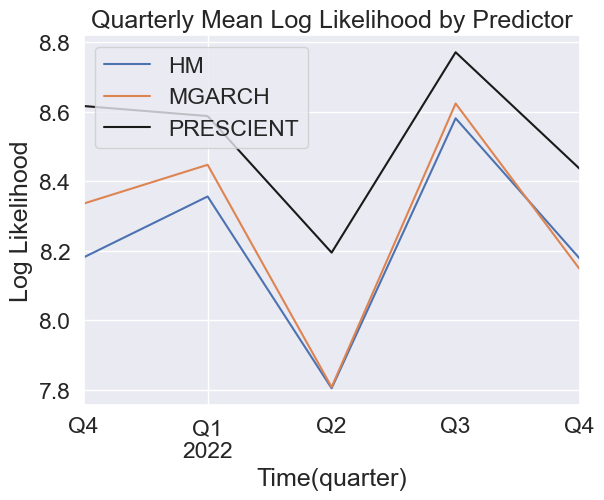



meanRegret: 0.200
stdRegret: 0.100
maxRegret: 0.400


meanLoglikelihoodHM: 8.200
stdLoglikelihoodHM: 0.300
maxLoglikelihoodHM: 8.600


meanLoglikelihoodMGARCH: 8.300
stdLoglikelihoodMGARCH: 0.300
maxLoglikelihoodMGARCH: 8.600


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800


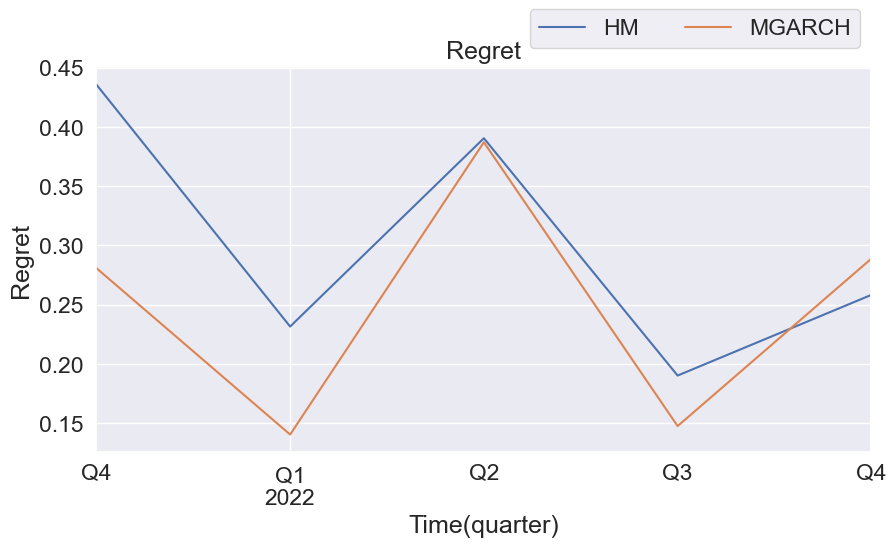

In [49]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["HM", "MGARCH", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [hybridModelDict, mgarchDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# now remove the first 19 entries from the predictor 0(hybrid dict)
hybridDictionary = predictors[0]
hybridDictionary = {k: hybridDictionary[k] for k in list(hybridDictionary)[19:]}
predictors[0] = hybridDictionary

# now remove the first 19 entries from the predictor 0(hybrid dict)
ewmaDictionary = predictors[1]
ewmaDictionary = {k: ewmaDictionary[k] for k in list(ewmaDictionary)[19:]}
predictors[1] = ewmaDictionary

# now remove the first 19 entries from the predictor 0(hybrid dict)
prescentDictionary = predictors[2]
prescentDictionary = {k: prescentDictionary[k] for k in list(prescentDictionary)[19:]}
predictors[2] = prescentDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))
print("size of the third predictor: " + str(len(predictors[2])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])
assert len(predictors[0]) == len(predictors[2])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()
assert predictors[0].keys() == predictors[2].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))
print("first timestamp of the third predictor: " + str(list(predictors[2].keys())[0]))

#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]
    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Regret')  # Set the y-axis label
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        hybridMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")